
# Sparkify Project Workspace

This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.


In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import split
from pyspark.sql.window import Window
from pyspark.sql.functions import countDistinct as fcountDistinct
from pyspark.sql.functions import sum as fsum
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.functions import count as fcount
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import numpy as np
import time
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportions_ztest

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

stack_overflow_data = 'mini_sparkify_event_data.json'


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
spark

In [4]:
df = spark.read.json(stack_overflow_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
# let us look up the dimensionality of the data
print((df.count(), len(df.columns)))

(286500, 18)


In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df.show(n=1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [8]:
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [9]:
# Converting Results to Pandas for better visibility
df_pandas = pd.DataFrame(df.take(5), columns=df.columns)
df_pandas

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


Checking for invalid or missing data - for example, records without proper entries in the variables **`userId`** or **`sessionId`**. 

In [10]:
# Checking for null values in the dataframe of pyspark
Dict_Null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
Dict_Null # The output in dict where key is column name and value is null values in that column

{'artist': 58392,
 'auth': 0,
 'firstName': 8346,
 'gender': 8346,
 'itemInSession': 0,
 'lastName': 8346,
 'length': 58392,
 'level': 0,
 'location': 8346,
 'method': 0,
 'page': 0,
 'registration': 8346,
 'sessionId': 0,
 'song': 58392,
 'status': 0,
 'ts': 0,
 'userAgent': 8346,
 'userId': 0}

There are no NANs in the **`userId`** or **`sessionId`** columns. However, there are a high number of NANs in other columns. 

Let us check for empty userId entries.

In [11]:
df.filter(df['userId']=='').count()

8346

There are several of observations (i.e. rows) with an empty **`userId`**.

How about empty entries in the variable **`sessionId`** ? 

In [12]:
df.filter(df['sessionId']=='').count()

0

All of the observations have a proper value in the variable **`sessionId`**.

Let us clean the spark dataframe. We remove all observations wothout an entry in **`userId`**.

In [13]:
df_clean = df.filter(df['userId']!='')

Let us check again for NANs in the cleaned spark datatframe.

In [14]:
Dict_Null_clean = {col:df_clean.filter(df_clean[col].isNull()).count() for col in df.columns}
Dict_Null_clean

{'artist': 50046,
 'auth': 0,
 'firstName': 0,
 'gender': 0,
 'itemInSession': 0,
 'lastName': 0,
 'length': 50046,
 'level': 0,
 'location': 0,
 'method': 0,
 'page': 0,
 'registration': 0,
 'sessionId': 0,
 'song': 50046,
 'status': 0,
 'ts': 0,
 'userAgent': 0,
 'userId': 0}

We have managed to reduce the number of NANs significantly by dropping all rows without a proper userId. Now the cleaning process for 15 of the 18 variables in the spark dataframe is complete. However, the variables **`artists`**, **`length`** and **`song`** still have got a high number of NANs. We could drop all rows with NANs in the spark datatframe, but we might loose a lot of valuable information this way. 

Let us take a look at the records that show NANs in the variables **`artists`**, **`length`** and **`song`**.

In [15]:
# For better visibility we display those records in a pandas datatframe.
df_pandas = pd.DataFrame(df_clean.where("artist is null").take(50046), columns=df_clean.columns)
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50046 entries, 0 to 50045
Data columns (total 18 columns):
artist           0 non-null object
auth             50046 non-null object
firstName        50046 non-null object
gender           50046 non-null object
itemInSession    50046 non-null int64
lastName         50046 non-null object
length           0 non-null object
level            50046 non-null object
location         50046 non-null object
method           50046 non-null object
page             50046 non-null object
registration     50046 non-null int64
sessionId        50046 non-null int64
song             0 non-null object
status           50046 non-null int64
ts               50046 non-null int64
userAgent        50046 non-null object
userId           50046 non-null object
dtypes: int64(5), object(13)
memory usage: 6.9+ MB


All of the NANs in the variables **`artists`**, **`length`** and **`song`** appear in the same records.  Therefore, these records might correspond to user-interactions without the user playing a song.

Let us try to verify this claim.

In [16]:
df_pandas.nunique() # Count number of distinct elements

artist               0
auth                 2
firstName          189
gender               2
itemInSession      859
lastName           173
length               0
level                2
location           114
method               2
page                18
registration       224
sessionId         2292
song                 0
status               3
ts               49696
userAgent           56
userId             224
dtype: int64

The records with NANs in the variables **`artists`**, **`length`** and **`song`** belong to a high number of distinct users interacting with our service at different times. Therefore, we should keep those records because they represent valid observations of user-interactions, albeit without the user playing any music. 

Next, in the spark dataframe we want to transform the time stamp variable **`ts`** and the **`registration`** variable into the two new variables **`timeanddate`** and **`registration_timeanddate`**, respectively. Both should show the time and the date in a human-readable string format.  
    
    Definition 
    The unix time stamp is a way to track time as a running total of seconds. This count starts at the Unix Epoch on January 1st, 1970 at UTC. Therefore, the unix time stamp is merely the number of seconds between a particular date and the Unix Epoch. 
    
    https://www.unixtimestamp.com/

#### New variable **`timeanddate`** (string representing date and time ) 

The string variable shows the date and time of the user record.

In [17]:
# User Defined Function
# convert datetime objects to its equivalent string
get_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

# We apply the User Defined Function to the ts variable
df_clean = df_clean.withColumn("timeanddate", get_datetime(df_clean.ts))


Let us have a look at the new column `timeanddate`.

In [18]:
df_clean.describe('timeanddate').show()

+-------+-------------------+
|summary|        timeanddate|
+-------+-------------------+
|  count|             278154|
|   mean|               null|
| stddev|               null|
|    min|2018-10-01 00:01:57|
|    max|2018-12-03 01:11:16|
+-------+-------------------+



#### New variable **`registration_timeanddate`** (string representing date and time ) 

The string variable shows the date and time when the user signed up for the service.

In [19]:
# We apply the User Defined Function to the registration variable
df_clean = df_clean.withColumn("registration_timeanddate", get_datetime(df_clean.registration))


#### New variable **`days_of_membership`** (Integer) 

For every record the numerical variable counts the number of days since the user signed up for the service. 

In [20]:
# User Defined Function
# convert datetime objects to its equivalent string

get_duration = udf(lambda x,y: float((x-y)/(1000*60*60*24)))

# We apply the User Defined Function to the ts variable
df_clean = df_clean.withColumn("days_of_membership", get_duration(df_clean.ts, df.registration))
df_clean = df_clean.withColumn("days_of_membership", df_clean["days_of_membership"].cast(IntegerType()))

In [21]:
df_clean.dtypes 

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string'),
 ('timeanddate', 'string'),
 ('registration_timeanddate', 'string'),
 ('days_of_membership', 'int')]

In [22]:
# Update temporary view
df_clean.createOrReplaceTempView("user_log_table")

Let us look at the distribution of the duration of membership in days by user.

In [23]:
df_days_of_membership = spark.sql('''
        SELECT DISTINCT userId, MAX(days_of_membership) AS duration_of_membership_in_days
        FROM user_log_table
        GROUP BY userId
        
        ''').toPandas().dropna()

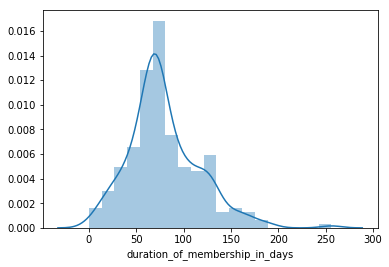

In [24]:
sns.distplot(df_days_of_membership.duration_of_membership_in_days);

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### Create a View And Run SQL Queries

The code below creates a temporary view against which we can run SQL queries.

In [25]:
# Create the view 'user_log_tables' or update this view if it already exists
df_clean.createOrReplaceTempView("user_log_table")

In [26]:
spark.sql('''
        SELECT DISTINCT(*)
        FROM user_log_table
        LIMIT 1
''').show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+------+-------------+---------+----+------+-------------+--------------------+------+-------------------+------------------------+------------------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|  page| registration|sessionId|song|status|           ts|           userAgent|userId|        timeanddate|registration_timeanddate|days_of_membership|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+------+-------------+---------+----+------+-------------+--------------------+------+-------------------+------------------------+------------------+
|  null|Logged In|     Alex|     M|           46|   Hogan|  null| free|Denver-Aurora-Lak...|   PUT|Logout|1535066380000|      100|null|   307|1538370563000|Mozilla/5.0 (Wind...|   101|2018-10-01 05:09:23|     2018-08-23 23:19:40|                38|
+---

#### Preliminary analysis

Let us count the number of records in the small database using a SQL querry.

In [27]:
spark.sql('''
          SELECT COUNT(*) 
          FROM user_log_table
          '''
          ).show()

+--------+
|count(1)|
+--------+
|  278154|
+--------+



Let us verify the result with the alternative DataFrames Coding.

In [28]:
df_clean.distinct().count()

278154

There are 278,154 records in the small subset of data we explore here.

Let us look at the summary statistics of the numerical variables in the dataset.

In [29]:
numerical_variables = spark.sql('''
        SELECT itemInSession, length, sessionId ,  status 
        FROM user_log_table
        ''').describe().show()

+-------+------------------+-----------------+------------------+------------------+
|summary|     itemInSession|           length|         sessionId|            status|
+-------+------------------+-----------------+------------------+------------------+
|  count|            278154|           228108|            278154|            278154|
|   mean|114.89918174824018|249.1171819778458|1042.5616241362698|209.10321620397335|
| stddev|  129.851729399489|99.23517921058361| 726.5010362219813|30.151388851328214|
|    min|                 0|          0.78322|                 1|               200|
|    max|              1321|       3024.66567|              2474|               404|
+-------+------------------+-----------------+------------------+------------------+



Let us have a look at the distribution of the variable **`itemInSession`**. 

In [30]:
itemInSession = spark.sql('''
        SELECT (itemInSession)
        FROM user_log_table
        ''')

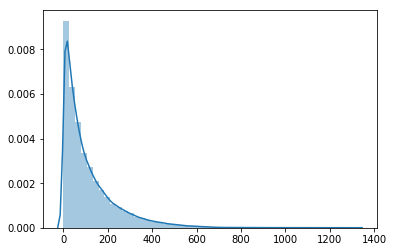

In [31]:
x = itemInSession.toPandas().dropna()

sns.distplot(x);

In [32]:
x.describe()

,itemInSession
count,278154.000000
mean,114.899182
std,129.851729
min,0.000000
25%,27.000000
50%,70.000000
75%,157.000000
max,1321.000000


The distribution of the variable **`itemInSession`** shows a strong positive skewness. 

    Definition Positive Skew:
    The right tail is longer; the mass of the distribution is concentrated on the left of the figure. The distribution is said to be right-skewed, right-tailed, or skewed to the right, despite the fact that the curve itself appears to be skewed or leaning to the left; right instead refers to the right tail being drawn out and, often, the mean being skewed to the right of a typical center of the data. A right-skewed distribution usually appears as a left-leaning curve. 
    https://en.wikipedia.org/wiki/Skewness
    
The median or 50%-quartile is 70 items and the mean is approx. 115 items in session. However, the strong positive skewness reflects the fact that at every new session of a user the variable **`itemInSession`** starts at 0 and increments by one for every new item in the session.   

#### **`length`** (Float: time in seconds)

The variable shows the length of a time (in seconds) that the song in the record was played. It does not show a value for user interactions other than playing a song.

Let us take a look at the distribution of the variable **`length`**. 

In [33]:
df_length = spark.sql('''
        SELECT length
        FROM user_log_table
        ''').toPandas().dropna()

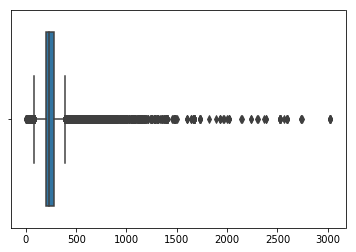

In [34]:
sns.boxplot(df_length);

In [35]:
df_length.describe()

,length
count,228108.000000
mean,249.117182
std,99.235179
min,0.783220
25%,199.888530
50%,234.500770
75%,277.158730
max,3024.665670


The distribution is almost symmetric with a median of 234 sec. and a mean of 249 sec. However, the distribution has strong outliers and the max. lenth of a song is 3025 seconds or 50 minutes. 

What is the start date and the end date of the records?

In [36]:
spark.sql('''
          SELECT min(timeanddate) AS start, max(timeanddate) AS end
          FROM user_log_table 
          '''
          ).collect()

[Row(start='2018-10-01 00:01:57', end='2018-12-03 01:11:16')]

The small dataset has about two months of data from Oct 1th, until Dec, 3rd, 2018. 


For example, let us take a look at all the records of the user with (**`userId`** = 2).

In [37]:
spark.sql('''
          SELECT firstname, lastname, page, timeanddate, itemInSession, registration
          FROM user_log_table 
          WHERE userID == '2'
          ORDER BY timeanddate ASC
          '''
          ).collect()

[Row(firstname='Natalee', lastname='Charles', page='NextSong', timeanddate='2018-10-08 04:49:55', itemInSession=0, registration=1536799770000),
 Row(firstname='Natalee', lastname='Charles', page='NextSong', timeanddate='2018-10-08 04:54:41', itemInSession=1, registration=1536799770000),
 Row(firstname='Natalee', lastname='Charles', page='NextSong', timeanddate='2018-10-08 04:57:41', itemInSession=2, registration=1536799770000),
 Row(firstname='Natalee', lastname='Charles', page='NextSong', timeanddate='2018-10-08 05:01:30', itemInSession=3, registration=1536799770000),
 Row(firstname='Natalee', lastname='Charles', page='NextSong', timeanddate='2018-10-08 05:05:38', itemInSession=4, registration=1536799770000),
 Row(firstname='Natalee', lastname='Charles', page='NextSong', timeanddate='2018-10-08 05:11:38', itemInSession=5, registration=1536799770000),
 Row(firstname='Natalee', lastname='Charles', page='NextSong', timeanddate='2018-10-08 05:15:37', itemInSession=6, registration=15367997

What is the start date and end date of the records of the user with (**`userId`** = 2)?

In [38]:
spark.sql('''
          SELECT min(timeanddate) AS start, max(timeanddate) AS end
          FROM user_log_table 
          WHERE userID == '2'
          '''
          ).collect()

[Row(start='2018-10-08 04:49:55', end='2018-11-21 22:30:04')]

Show all the pages that users have visited at Sparkify.

In [39]:
spark.sql('''
          SELECT DISTINCT page
          FROM user_log_table 
          ORDER BY page ASC
          '''
          ).show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



How many female and male users do we have in the data set?

In [40]:
spark.sql('''
        SELECT gender,COUNT(DISTINCT userId) AS No_of_Users
        FROM user_log_table
        GROUP BY gender
        ORDER BY No_of_Users ASC
        '''
        ).show()

+------+-----------+
|gender|No_of_Users|
+------+-----------+
|     F|        104|
|     M|        121|
+------+-----------+



There are 225 users in the data set, and 104 are female and 121 are male. 

In [41]:
spark.sql('''
        SELECT level,COUNT(DISTINCT userId) AS No_of_Users
        FROM user_log_table
        GROUP BY level
        ORDER BY No_of_Users DESC
''').show()

+-----+-----------+
|level|No_of_Users|
+-----+-----------+
| free|        195|
| paid|        165|
+-----+-----------+



Several users changed the level from `free`to `paid`and vice versa.  

#### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

How do we know that a user has cancelled the service? 

In [42]:
spark.sql('''
        SELECT auth, COUNT(userId) AS No_of_Users
        FROM user_log_table
        GROUP BY auth
        ORDER BY No_of_Users DESC
        '''
         ).show()

+---------+-----------+
|     auth|No_of_Users|
+---------+-----------+
|Logged In|     278102|
|Cancelled|         52|
+---------+-----------+



There are a total of 278,154 records in this small dataset, and the variable **`auth`** (i.e. authentication) flags 52 of those records as `cancelled`. 

How many records show that the user have visited the **`page`** `Cancellation Confirmation` ?

In [43]:
spark.sql('''
        SELECT page,COUNT(userId) AS No_of_Users
        FROM user_log_table
        GROUP BY page
        ORDER BY No_of_Users ASC
''').show()

+--------------------+-----------+
|                page|No_of_Users|
+--------------------+-----------+
|              Cancel|         52|
|Cancellation Conf...|         52|
|    Submit Downgrade|         63|
|      Submit Upgrade|        159|
|               Error|        252|
|       Save Settings|        310|
|               About|        495|
|             Upgrade|        499|
|                Help|       1454|
|            Settings|       1514|
|           Downgrade|       2055|
|         Thumbs Down|       2546|
|              Logout|       3226|
|         Roll Advert|       3933|
|          Add Friend|       4277|
|     Add to Playlist|       6526|
|                Home|      10082|
|           Thumbs Up|      12551|
|            NextSong|     228108|
+--------------------+-----------+



Let us look at the 52 records where the variable **`page`** shows a `Cancellation Confirmation`. Does the variable **`auth`** show `Cancelled`for those records? 

In [44]:
df_cancelled = spark.sql('''
          SELECT userId, auth, level, firstname, lastname, page, timeanddate, days_of_membership
          FROM user_log_table 
          WHERE page == 'Cancellation Confirmation'
          ORDER BY  timeanddate DESC
          '''
         ).toPandas()

In [45]:
df_cancelled

,userId,auth,level,firstname,lastname,page,timeanddate,days_of_membership
0,100007,Cancelled,paid,Piper,Cook,Cancellation Confirmation,2018-11-29 11:45:09,115
1,100021,Cancelled,free,Rayden,Phillips,Cancellation Confirmation,2018-11-25 11:03:02,64
2,100015,Cancelled,paid,Tina,Thompson,Cancellation Confirmation,2018-11-24 15:35:53,67
3,300001,Cancelled,paid,Antonina,Kennedy,Cancellation Confirmation,2018-11-23 21:42:24,188
4,100014,Cancelled,paid,Rodrigo,Carey,Cancellation Confirmation,2018-11-20 19:04:09,85
5,53,Cancelled,paid,Sebastian,Wang,Cancellation Confirmation,2018-11-19 12:34:56,53
6,200020,Cancelled,free,Keegan,Rivera,Cancellation Confirmation,2018-11-17 16:40:42,75
7,200016,Cancelled,free,Charlotte,Frazier,Cancellation Confirmation,2018-11-16 08:17:58,55
8,200017,Cancelled,paid,James,Dickerson,Cancellation Confirmation,2018-11-15 20:16:43,60
9,70,Cancelled,paid,Chayse,Keller,Cancellation Confirmation,2018-11-14 22:34:27,145


In [46]:
df_cancelled["days_of_membership"] = pd.to_numeric(df_cancelled["days_of_membership"])

In [47]:
df_cancelled["days_of_membership"].describe()

count     52.000000
mean      56.807692
std       36.602817
min        5.000000
25%       30.500000
50%       50.500000
75%       73.500000
max      188.000000
Name: days_of_membership, dtype: float64

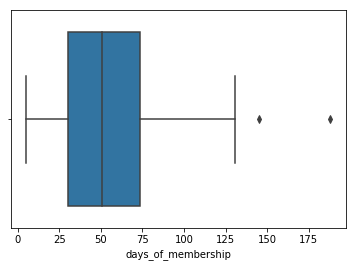

In [48]:
#x = df_cancelled['days_of_membership']

sns.boxplot(df_cancelled.days_of_membership);

In [49]:
df_cancelled.days_of_membership.describe()

count     52.000000
mean      56.807692
std       36.602817
min        5.000000
25%       30.500000
50%       50.500000
75%       73.500000
max      188.000000
Name: days_of_membership, dtype: float64

In [50]:
# lambda function for the churn event 
flag_event = udf(lambda page : 1 if page == 'Cancellation Confirmation' else 0, IntegerType())

In [51]:
# Create binary churn_event variable of type integer
df_clean = df_clean.withColumn('churn_event',flag_event('page'))

In [52]:
# show summary statistics for the new variable
df_clean.describe('churn_event').show()

+-------+--------------------+
|summary|         churn_event|
+-------+--------------------+
|  count|              278154|
|   mean|1.869467992550889E-4|
| stddev|0.013671595449116164|
|    min|                   0|
|    max|                   1|
+-------+--------------------+



In [53]:
# Update temporary view
df_clean.createOrReplaceTempView("user_log_table")

Let us look at the records with churn events.

In [54]:
spark.sql('''
          SELECT userId, auth, level, firstname, lastname, page, timeanddate, churn_event
          FROM user_log_table 
          WHERE churn_event == 1
          ORDER BY  timeanddate DESC
          '''
         ).show(100)

+------+---------+-----+---------+---------+--------------------+-------------------+-----------+
|userId|     auth|level|firstname| lastname|                page|        timeanddate|churn_event|
+------+---------+-----+---------+---------+--------------------+-------------------+-----------+
|100007|Cancelled| paid|    Piper|     Cook|Cancellation Conf...|2018-11-29 11:45:09|          1|
|100021|Cancelled| free|   Rayden| Phillips|Cancellation Conf...|2018-11-25 11:03:02|          1|
|100015|Cancelled| paid|     Tina| Thompson|Cancellation Conf...|2018-11-24 15:35:53|          1|
|300001|Cancelled| paid| Antonina|  Kennedy|Cancellation Conf...|2018-11-23 21:42:24|          1|
|100014|Cancelled| paid|  Rodrigo|    Carey|Cancellation Conf...|2018-11-20 19:04:09|          1|
|    53|Cancelled| paid|Sebastian|     Wang|Cancellation Conf...|2018-11-19 12:34:56|          1|
|200020|Cancelled| free|   Keegan|   Rivera|Cancellation Conf...|2018-11-17 16:40:42|          1|
|200016|Cancelled| f

Next, we want to create a new variable **`Churn`** that indicicates all of the records of users who later cancel the service. We can use a SQL Windows function to get the maximum value of the variable **`churn_event`** for every **`userId`**.   

    A window function performs a calculation across a set of table rows that are somehow related to the current row. This is comparable to the type of calculation that can be done with an aggregate function. But unlike regular aggregate functions, use of a window function does not cause rows to become grouped into a single output row — the rows retain their separate identities. Behind the scenes, the window function is able to access more than just the current row of the query result. https://www.postgresql.org/docs/9.1/tutorial-window.html
    
    
    
A SQL querry with a Windows function would look like this:    

In [55]:
spark.sql('''
          SELECT userId, max(churn_event)
          OVER (PARTITION BY userID)
          FROM user_log_table 
          ORDER BY  timeanddate 
          '''
         ).show(50)

+------+----------------------------------------------------------------------------------------------------+
|userId|max(churn_event) OVER (PARTITION BY userID ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)|
+------+----------------------------------------------------------------------------------------------------+
|    30|                                                                                                   0|
|     9|                                                                                                   0|
|    30|                                                                                                   0|
|     9|                                                                                                   0|
|    30|                                                                                                   0|
|     9|                                                                                                   0|
|     9|  

Let us use the pyspark sql function ***Window*** to partition the spark dataframe by **`userId`**  in the same way as with the SQL querry before without limitations on the number of rows (i.e. ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING). 

In [56]:
user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

We want to apply the Windows function to create a new column **`Churn`**. We use the maximum value of the variable **`churn_event`** for every record of a **`userId`**.

In [57]:
df_clean      = df_clean.withColumn('Churn',fmax('churn_event').over(user_window))

Let us look at the summary statistics for the new variable **`Churn`**.

In [58]:
# show summary statistics for the new variable
df_clean.describe('Churn').show()

+-------+-------------------+
|summary|              Churn|
+-------+-------------------+
|  count|             278154|
|   mean|0.16129194618808287|
| stddev|0.36780068056308857|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



About 16 percent of the records in the small dataset belong to users who eventually churned. 

In [59]:
# Update temporary view
df_clean.createOrReplaceTempView("user_log_table")

### Users Downgrade Their Accounts

Let us look into the `Downgrade` events.

In [60]:
spark.sql('''
          SELECT COUNT(DISTINCT userId)
          FROM user_log_table 
          WHERE page == 'Downgrade'
          
          '''
         ).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   154|
+----------------------+



Let us compare this number with the total number of users.

In [61]:
spark.sql('''
          SELECT COUNT(DISTINCT userId)
          FROM user_log_table 
          
         
          '''
         ).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   225|
+----------------------+



A high ratio of 154/225 or 68 percent of our users visit the **`page`** `downgrade` at some point. How many do submit the downgrade?

In [62]:
spark.sql('''
          SELECT COUNT(DISTINCT userId)
          FROM user_log_table 
          WHERE page == 'Submit Downgrade'
         
          '''
         ).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                    49|
+----------------------+



How many users both downgrade and then churn the service eventually?

In [63]:
spark.sql('''
          SELECT Churn, COUNT(DISTINCT userId) AS Submit_Downgrade
          FROM user_log_table 
          WHERE page == 'Submit Downgrade' 
          GROUP BY Churn
         
          '''
         ).show()

+-----+----------------+
|Churn|Submit_Downgrade|
+-----+----------------+
|    1|               9|
|    0|              40|
+-----+----------------+



In [64]:
spark.sql('''
          SELECT DISTINCT userId, page, Churn, level
          FROM user_log_table 
          WHERE page == 'Submit Downgrade' OR page == 'Cancellation Confirmation'
          ORDER BY userId
         
          '''
         ).show(50)

+------+--------------------+-----+-----+
|userId|                page|Churn|level|
+------+--------------------+-----+-----+
|   100|    Submit Downgrade|    0| paid|
|100001|Cancellation Conf...|    1| free|
|100003|Cancellation Conf...|    1| free|
|100004|    Submit Downgrade|    0| paid|
|100005|Cancellation Conf...|    1| free|
|100006|Cancellation Conf...|    1| free|
|100007|Cancellation Conf...|    1| paid|
|100008|    Submit Downgrade|    0| paid|
|100009|    Submit Downgrade|    1| paid|
|100009|Cancellation Conf...|    1| free|
|100011|Cancellation Conf...|    1| free|
|100012|    Submit Downgrade|    1| paid|
|100012|Cancellation Conf...|    1| free|
|100013|Cancellation Conf...|    1| paid|
|100014|Cancellation Conf...|    1| paid|
|100015|Cancellation Conf...|    1| paid|
|100015|    Submit Downgrade|    1| paid|
|100016|    Submit Downgrade|    0| paid|
|100017|Cancellation Conf...|    1| free|
|100018|    Submit Downgrade|    0| paid|
|100019|Cancellation Conf...|    1

Let us find when users downgrade their accounts and then flag those log entries. Then we use a Window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

In [65]:
df_clean.filter("page = 'Submit Downgrade'").show(1)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+------------------------+------------------+-----------+-----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|        timeanddate|registration_timeanddate|days_of_membership|churn_event|Churn|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+------------------------+------------------+-----------+-----+
|  null|Logged In|    Alexi|     F|           41|  Warren|  null| paid|Spokane-Spokane V...|   PUT|Submit Downgrade|1532482662000|      859|null|   307|1539608060000|Moz

In [66]:
df_clean.select(["userId", "firstname", "page", "level", "song"]).where(df_clean.userId == "100").collect()

[Row(userId='100', firstname='Colin', page='NextSong', level='paid', song='Bring Me To Life'),
 Row(userId='100', firstname='Colin', page='NextSong', level='paid', song='Strut (1993 Digital Remaster)'),
 Row(userId='100', firstname='Colin', page='Thumbs Down', level='paid', song=None),
 Row(userId='100', firstname='Colin', page='NextSong', level='paid', song='Pretty Little Angel'),
 Row(userId='100', firstname='Colin', page='NextSong', level='paid', song='City On Our Knees'),
 Row(userId='100', firstname='Colin', page='NextSong', level='paid', song='Monday Morning (LP Version)'),
 Row(userId='100', firstname='Colin', page='NextSong', level='paid', song='Your Place [Album Version]'),
 Row(userId='100', firstname='Colin', page='NextSong', level='paid', song='Shoulder Lean [Featuring T.I.] (Amended Album Version) (AKA Radio Version)'),
 Row(userId='100', firstname='Colin', page='Add to Playlist', level='paid', song=None),
 Row(userId='100', firstname='Colin', page='NextSong', level='paid'

In [67]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df_clean             = df_clean.withColumn("downgrade_event", flag_downgrade_event("page"))

In [68]:
df_clean.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', timeanddate='2018-11-21 18:12:32', registration_timeanddate='2018-09-27 02:45:40', days_of_membership=55, churn_event=0, Churn=0, downgrade_event=0)

#### New variable **`phase`** (integer)

The numerical variable shows the number of times a user downgraded the service already. The variable has one value for all the records of a user.

In [69]:
df_clean  = df_clean.withColumn("phase", fsum("downgrade_event").over(user_window))

In [70]:
df_clean.select(["firstname", "timeanddate", "page", "level", "downgrade_event", "phase"])\
           .where(df_clean.userId == "13")\
           .sort("ts").collect()

[Row(firstname='Anika', timeanddate='2018-10-01 05:38:09', page='NextSong', level='free', downgrade_event=0, phase=2),
 Row(firstname='Anika', timeanddate='2018-10-01 05:45:46', page='NextSong', level='free', downgrade_event=0, phase=2),
 Row(firstname='Anika', timeanddate='2018-10-01 05:48:39', page='NextSong', level='free', downgrade_event=0, phase=2),
 Row(firstname='Anika', timeanddate='2018-10-01 05:50:53', page='NextSong', level='free', downgrade_event=0, phase=2),
 Row(firstname='Anika', timeanddate='2018-10-01 05:51:20', page='Add to Playlist', level='free', downgrade_event=0, phase=2),
 Row(firstname='Anika', timeanddate='2018-10-01 05:53:26', page='NextSong', level='free', downgrade_event=0, phase=2),
 Row(firstname='Anika', timeanddate='2018-10-01 05:55:44', page='NextSong', level='free', downgrade_event=0, phase=2),
 Row(firstname='Anika', timeanddate='2018-10-01 05:55:45', page='Logout', level='free', downgrade_event=0, phase=2),
 Row(firstname='Anika', timeanddate='2018-1

In [71]:
# Update temporary view
df_clean.createOrReplaceTempView("user_log_table")

Let us look at the distribution of  **`phase`**.

In [72]:
spark.sql('''
        SELECT Churn, phase, COUNT(DISTINCT userId) AS no_of_users
        FROM user_log_table
        GROUP BY Churn , phase 
        ORDER BY Churn ASC, phase ASC
        ''').show()


+-----+-----+-----------+
|Churn|phase|no_of_users|
+-----+-----+-----------+
|    0|    0|        133|
|    0|    1|         28|
|    0|    2|         10|
|    0|    3|          2|
|    1|    0|         43|
|    1|    1|          9|
+-----+-----+-----------+



Let us take a look at the distribution of the numerical variables for users who churned the service.

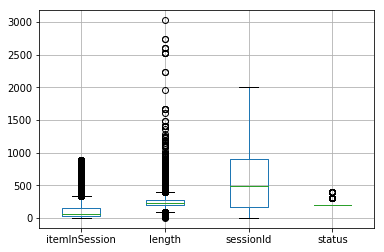

In [73]:
numerical_variables_churn = spark.sql('''
        SELECT userId, itemInSession, length, sessionId ,  status 
        FROM user_log_table
        WHERE Churn == 1
        ''').toPandas()

numerical_variables_churn.boxplot();

How do this distributions for users who churned compare to the distribution for users who contiune the service? 

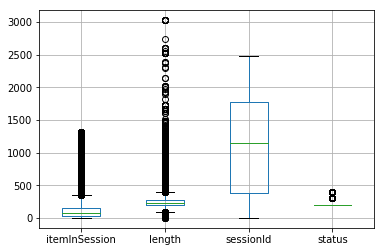

In [74]:
numerical_variables_nochurn = spark.sql('''
        SELECT itemInSession, length, sessionId ,  status 
        FROM user_log_table
        WHERE Churn == 0
        ''').toPandas()

numerical_variables_nochurn.boxplot();

In [75]:
(numerical_variables_nochurn.describe() - numerical_variables_churn.describe())

,itemInSession,length,sessionId,status
count,188426.000000,155320.000000,188426.000000,188426.000000
mean,6.755853,0.576340,511.793638,0.173109
std,8.428961,-3.759094,220.497172,0.331602
min,0.000000,-3.265310,0.000000,0.000000
25%,1.000000,0.548570,206.000000,0.000000
50%,5.000000,0.757560,654.000000,0.000000
75%,12.000000,1.528163,871.000000,0.000000
max,432.000000,0.000000,471.000000,0.000000


Users who continue the service tend to have more interactions with us. On average, continueing users listen to more songs during sessions  (**`itemInSession`**) and they have more sessions over time (**`sessionId`**). In contrast, there is no meaningful difference between the two groups in the length of the songs they play (`length`) or in the status codes of their HTTP requests (e.g. `Bad Request 400 Error`).



In [76]:
numerical_variables_nochurn.describe()

,itemInSession,length,sessionId,status
count,233290.000000,191714.000000,233290.000000,233290.000000
mean,115.988847,249.209135,1125.109816,209.131137
std,131.150670,98.625883,732.553850,30.204613
min,0.000000,0.783220,1.000000,200.000000
25%,27.000000,199.940770,377.000000,200.000000
50%,71.000000,234.657510,1150.000000,200.000000
75%,159.000000,277.158730,1775.000000,200.000000
max,1321.000000,3024.665670,2474.000000,404.000000


#### New Variable **`no_of_items`** (Integer)

The numerical variable shows the total number of user interactions of a user.

In [77]:
df_clean  = df_clean.withColumn("no_of_items", fcount ("itemInSession").over(user_window))

In [78]:
df_clean.select(["itemInSession", "timeanddate", "page", ("sessionId") , "no_of_items"])\
           .where(df_clean.userId == "2")\
           .sort("ts").collect()

[Row(itemInSession=0, timeanddate='2018-10-08 04:49:55', page='NextSong', sessionId=1, no_of_items=899),
 Row(itemInSession=1, timeanddate='2018-10-08 04:54:41', page='NextSong', sessionId=1, no_of_items=899),
 Row(itemInSession=2, timeanddate='2018-10-08 04:57:41', page='NextSong', sessionId=1, no_of_items=899),
 Row(itemInSession=3, timeanddate='2018-10-08 05:01:30', page='NextSong', sessionId=1, no_of_items=899),
 Row(itemInSession=4, timeanddate='2018-10-08 05:05:38', page='NextSong', sessionId=1, no_of_items=899),
 Row(itemInSession=5, timeanddate='2018-10-08 05:11:38', page='NextSong', sessionId=1, no_of_items=899),
 Row(itemInSession=6, timeanddate='2018-10-08 05:15:37', page='NextSong', sessionId=1, no_of_items=899),
 Row(itemInSession=7, timeanddate='2018-10-08 05:18:30', page='NextSong', sessionId=1, no_of_items=899),
 Row(itemInSession=8, timeanddate='2018-10-08 05:20:04', page='NextSong', sessionId=1, no_of_items=899),
 Row(itemInSession=9, timeanddate='2018-10-08 05:21:35'

In [79]:
# Update temporary view
df_clean.createOrReplaceTempView("user_log_table")

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### **`Authentication`**  (Logged In / Cancelled)

The categorical variable **`auth`** can take one of two possible values, `Logged In`or `Cancelled`.


In [80]:
df_clean.dropDuplicates(["userId"]).groupby(["Churn", "auth"]).count().sort("Churn").show()

+-----+---------+-----+
|Churn|     auth|count|
+-----+---------+-----+
|    0|Logged In|  173|
|    1|Cancelled|   51|
|    1|Logged In|    1|
+-----+---------+-----+



#### **`Gender`** (Female/Male)

The categorical variable **`gender`** can take one of two possible values, `F`or `M`.


In [81]:
spark.sql('''
          SELECT Churn, gender, COUNT(DISTINCT userId) AS No_of_Users
          FROM user_log_table 
          GROUP BY Churn, gender
          ORDER BY Churn DESC, gender
         
          '''
         ).show()

+-----+------+-----------+
|Churn|gender|No_of_Users|
+-----+------+-----------+
|    1|     F|         20|
|    1|     M|         32|
|    0|     F|         84|
|    0|     M|         89|
+-----+------+-----------+



Let us use a statistical proportions test to evaluate if females and males are equally likely to cancel the service (null hypothesis). 


##### Definition p-value
    In null hypothesis significance testing, the p-value is the probability of obtaining test results at least as 
    extreme as the results actually observed, under the assumption that the null hypothesis is correct. 
    A very small p-value means that such an extreme observed outcome would be very unlikely under the null hypothesis. 

In [82]:
# test for proportions based on normal (z) test

count = np.array([20, 32])           # the number of successes in nobs trials. If this is array_like, 
                                     # then the assumption is that this represents the number of successes for each 
                                     # independent sample
nobs  = np.array([(20+84), (32+89)]) # the number of trials or observations, with the same length as count.


stat, pval  = proportions_ztest(count, nobs, value=None, alternative='two-sided', prop_var=False)

print('{0:0.2f} test statistic for the z-test'.format(stat))
print('{0:0.3f} p-value for the z-test'.format(pval))


-1.28 test statistic for the z-test
0.201 p-value for the z-test


We cannot reject the null-hypothesis that gender has no impact on churn probability because the p-value of 0.201 is too high. There is a 20 percent chance of obtaining the observed statistic or one more extreme in favour of the alternative hypothesis. 

#### **`lenth`** (in seconds)

The numerical variable **`length`** stores the lenth of time a user listens to a song. 


In [83]:
spark.sql('''
          SELECT Churn, AVG(length) AS average_length, MIN(length) AS minimum_length, 
                 MAX(length) AS maximum_length, SUM(length) AS total_length
          FROM user_log_table 
          GROUP BY Churn
          ORDER BY Churn DESC
         
          '''
         ).show()

+-----+------------------+--------------+--------------+-------------------+
|Churn|    average_length|minimum_length|maximum_length|       total_length|
+-----+------------------+--------------+--------------+-------------------+
|    1| 248.6327956440622|       4.04853|    3024.66567|      9048741.96467|
|    0|249.20913538880808|       0.78322|    3024.66567|4.777688018192995E7|
+-----+------------------+--------------+--------------+-------------------+



There is no impact of the variable **`length`** on the **`churn`** variable. There is almost no difference in the average length of the songs for both groups of users. 

#### **`level`** (free/paid)

The categorical variable **`level`** takes one of two possible values, `free`or `paid`.


In [84]:
spark.sql('''
        SELECT Churn, level,COUNT(DISTINCT userId) AS No_of_Users
        FROM user_log_table
        GROUP BY Churn, level
        ORDER BY No_of_Users DESC
''').show()

+-----+-----+-----------+
|Churn|level|No_of_Users|
+-----+-----+-----------+
|    0| free|        149|
|    0| paid|        129|
|    1| free|         46|
|    1| paid|         36|
+-----+-----+-----------+



In [85]:
# test for proportions based on normal (z) test

count = np.array([46, 36])           # the number of successes in nobs trials. If this is array_like, 
                                     # then the assumption is that this represents the number of successes for each 
                                     # independent sample
nobs  = np.array([(46+149), (36+128)]) # the number of trials or observations, with the same length as count.


stat, pval  = proportions_ztest(count, nobs, value=None, alternative='two-sided', prop_var=False)

print('{0:0.2f} test statistic for the z-test'.format(stat))
print('{0:0.3f} p-value for the z-test'.format(pval))


0.37 test statistic for the z-test
0.713 p-value for the z-test


The categorical variable **`level`** has no statistically significant impact on churn. Therefore, we cannot reject the null-hypothesis that both groups of users have the same probability to churn the service.

#### **`method`** (GET / PUT)

The categorical variable **`method`** takes one of two possible values, `GET`or `PUT`. The variable shows the HTTP Request Method for each record. HTTP works as a request-response protocol between a client and server. GET is used to request data from a specified resource. PUT is used to send data to a server to create/update a resource.


In [86]:
spark.sql('''
        SELECT Churn, method,COUNT(userId) AS No_of_records
        FROM user_log_table
        GROUP BY method, Churn
        ORDER BY No_of_records DESC
''').show()

+-----+------+-------------+
|Churn|method|No_of_records|
+-----+------+-------------+
|    0|   PUT|       216691|
|    1|   PUT|        41127|
|    0|   GET|        16599|
|    1|   GET|         3737|
+-----+------+-------------+



In [87]:
print('{0:0.1f} percent is the ratio of records with GET method for all users.'.format(((16599+3737) /(278154))*100))

7.3 percent is the ratio of records with GET method for all users.


In [88]:
print('{0:0.1f} percent is the ratio of records with GET method for churned users.'.format((3737) /(3737+41127)*100))

8.3 percent is the ratio of records with GET method for churned users.


In [89]:
print('{0:0.1f} percent is the ratio of records with GET method for active users.'.format((16599) /(16599+216691)*100))

7.1 percent is the ratio of records with GET method for active users.


In [204]:
# test for proportions based on normal (z) test

count = np.array([3737, 16599])      # the number of successes in nobs trials. If this is array_like, 
                                     # then the assumption is that this represents the number of successes for each 
                                     # independent sample
nobs  = np.array([(3737+41127), (16599+216691)]) # the number of trials or observations, with the same length as count.


stat, pval  = proportions_ztest(count, nobs, value=None, alternative='two-sided', prop_var=False)

print('{0:0.2f} test statistic for the z-test'.format(stat))
print('{0:0.3f} p-value for the z-test'.format(pval))


9.05 test statistic for the z-test
0.000 p-value for the z-test


The p-value is statistically significant
Here the p-value is below our threshold of significance (typically p < 0.05), and we can reject the null hypothesis, but this does not mean that there is a 95% probability that the alternative hypothesis is true. The p-value is conditional upon the null hypothesis being true, but is unrelated to the truth or falsity of the alternative hypothesis.

The null hypothesis states that there is no relationship between the two variables **`Churn`** and **`method`** (one variable does not affect the other). It states the results are due to chance and are not significant in terms of supporting the idea being investigated. 

The alternative hypothesis states that the independent variable **`Churn`** did affect the dependent variable **`method`**, and the results are significant in terms of supporting the theory being investigated (i.e. not due to chance).

Source: https://www.simplypsychology.org/p-value.html

However, statistical significance does not that prove practical significance.

#### **`Artist`** (string)


The variable **`artist`** shows the name of the artist performing the **`song`** played by the user.  

In [91]:
# How many artist are in the data set?
spark.sql('''
        SELECT COUNT(DISTINCT Artist) AS no_of_artists
        FROM user_log_table 
        '''
        ).show()

+-------------+
|no_of_artists|
+-------------+
|        17655|
+-------------+



In [92]:
# How many songs were played from the most played artist?
artist_active = spark.sql('''
        SELECT Artist, COUNT(Artist) AS active_users 
        FROM user_log_table 
        WHERE Churn == 0
        GROUP BY Artist 
        ORDER BY active_users DESC 
        
        '''
        ).toPandas()

In [93]:
artist_churn = spark.sql('''
        SELECT Artist, COUNT(Artist) AS churned_users 
        FROM user_log_table 
        WHERE Churn == 1
        GROUP BY Artist 
        ORDER BY churned_users DESC 
        
        '''
        ).toPandas()

In [94]:
artist_active = artist_active.set_index('Artist')   
artist_churn   = artist_churn.set_index('Artist')   

In [95]:
df_artist= pd.concat([artist_active.groupby('Artist').sum(), artist_churn.groupby('Artist').sum()], \
                              axis=1, join="outer", sort=True)

In [96]:
df_artist = df_artist.sort_values(by=['active_users', 'churned_users'], ascending=False)


In [97]:
df_artist = df_artist.head(50)

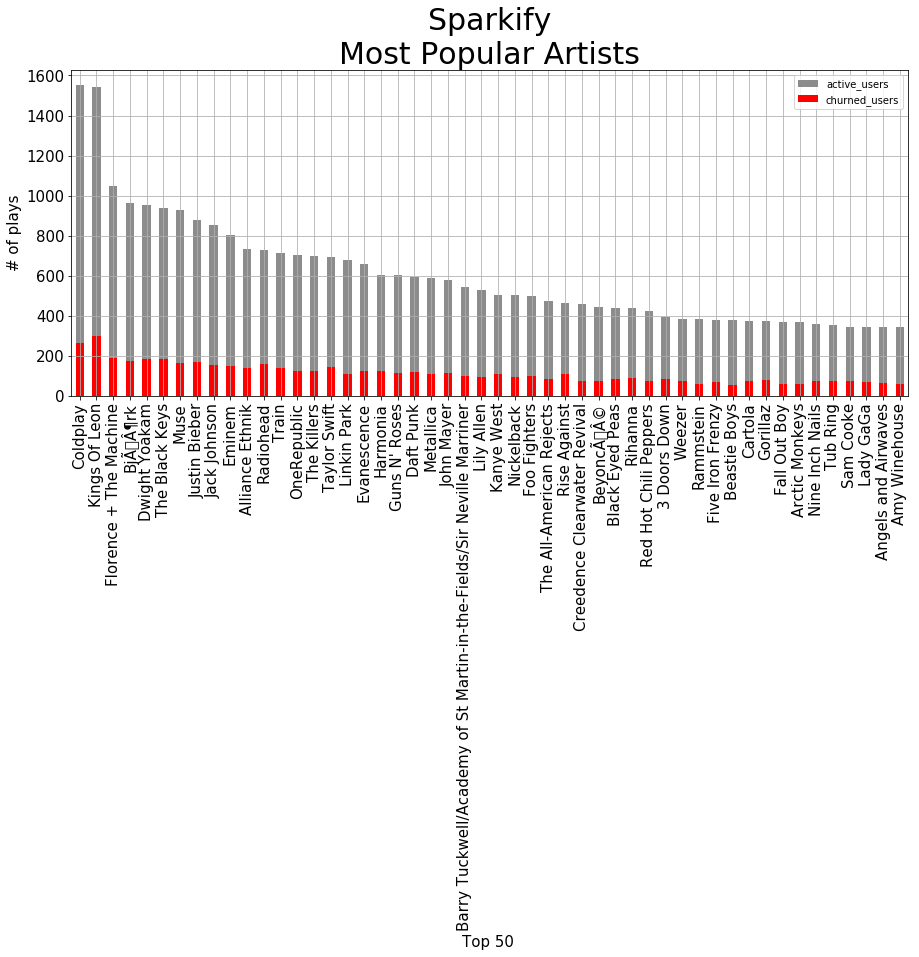

In [98]:
plt.title('Sparkify\nMost Popular Artists', fontsize=30)

ax = df_artist['active_users'].plot(kind='bar', color ='0.55', figsize=(15, 6), legend=True, fontsize=15)
ax = df_artist['churned_users'].plot(kind='bar', color ='r', legend=True, fontsize=15)
ax.set_xlabel("Top 50 ", fontsize=15)
ax.set_ylabel("# of plays", fontsize=15)
plt.grid(True)
plt.show()

Active users and churned users listen to the same artists.

In [99]:
# Here is an alternative solution
# Get the artist play counts
play_counts = spark.sql("SELECT Artist, COUNT(Artist) AS plays \
        FROM user_log_table \
        GROUP BY Artist")

In [100]:
# save the results in a new view
play_counts.createOrReplaceTempView("artist_counts")

In [101]:
play_counts.show()

+--------------------+-----+
|              Artist|plays|
+--------------------+-----+
|      The Black Keys| 1125|
|         Silverstein|   60|
|           Kate Nash|   99|
|        Yann Tiersen|  139|
|    Jane's Addiction|   68|
|          Tim Hughes|   39|
|          Carl Craig|    3|
|Dashboard Confess...|   98|
|Yonder Mountain S...|   63|
|           Los Lobos|   45|
|Pete Rock & C.L. ...|    2|
|        Ziggy Marley|   28|
|      Jarabe De Palo|   83|
|               Rufio|   13|
|WC And The Maad C...|    1|
|      Jorge Gonzalez|   24|
|                Silk|   22|
|  The Watts Prophets|    6|
|            La Shica|    2|
|        Generation X|   19|
+--------------------+-----+
only showing top 20 rows



In [102]:
# we use a self join to find where the max play equals the count value
spark.sql('''
          SELECT a2.Artist, a2.plays 
          FROM (SELECT max(plays) AS max_plays FROM artist_counts) AS a1 
          JOIN artist_counts AS a2 
          ON a1.max_plays = a2.plays 
          '''
          ).show()

+-------------+-----+
|       Artist|plays|
+-------------+-----+
|Kings Of Leon| 1841|
+-------------+-----+



How many songs do active users listen to on average between visiting the home page? 

In [103]:
# SELECT CASE WHEN 1 > 0 THEN 1 WHEN 2 > 0 THEN 2.0 ELSE 1.2 END;
is_home = spark.sql('''
            SELECT userID, page, ts, CASE WHEN page = 'Home' THEN 1 ELSE 0 END AS is_home 
            FROM user_log_table 
            WHERE ((page = 'NextSong') OR (page = 'Home')) AND Churn == 0
            '''
            )

# keep the results in a new view
is_home.createOrReplaceTempView("is_home_table")

# find the cumulative sum over the is_home column
cumulative_sum = spark.sql('''
            SELECT * , SUM(is_home) 
            OVER (PARTITION BY userID ORDER BY ts DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS period 
            FROM is_home_table
            '''
            )
            

# keep the results in a view
cumulative_sum.createOrReplaceTempView("period_table")

# find the average count for NextSong
spark.sql('''
          SELECT AVG(count_results) AS average_songs_active_users
          FROM (SELECT COUNT(*) AS count_results FROM period_table \
          GROUP BY userID, period, page HAVING page = 'NextSong') AS counts
          '''
          ).show()

+--------------------------+
|average_songs_active_users|
+--------------------------+
|        23.768162658070914|
+--------------------------+



How many songs do churned users listen to on average between visiting the home page? 

In [104]:
# SELECT CASE WHEN 1 > 0 THEN 1 WHEN 2 > 0 THEN 2.0 ELSE 1.2 END;
is_home = spark.sql('''
            SELECT userID, page, ts, CASE WHEN page = 'Home' THEN 1 ELSE 0 END AS is_home 
            FROM user_log_table 
            WHERE ((page = 'NextSong') OR (page = 'Home')) AND Churn == 1
            '''
            )

# keep the results in a new view
is_home.createOrReplaceTempView("is_home_table")

# find the cumulative sum over the is_home column
cumulative_sum = spark.sql('''
            SELECT * , SUM(is_home) 
            OVER (PARTITION BY userID ORDER BY ts DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS period 
            FROM is_home_table
            '''
            )
            

# keep the results in a view
cumulative_sum.createOrReplaceTempView("period_table")

# find the average count for NextSong
spark.sql('''
          SELECT AVG(count_results)  AS average_songs_churned_users
          FROM (SELECT COUNT(*) AS count_results FROM period_table \
          GROUP BY userID, period, page HAVING page = 'NextSong') AS counts
          '''
          ).show()

+---------------------------+
|average_songs_churned_users|
+---------------------------+
|          22.67538940809969|
+---------------------------+



#### **`location`** (string city, state)

The categorical variable **`location`** shows the municipality and the US state where the users are located. It takes one of more than 100 possible values, showing the name of a city, and the US state. We are most interested in location by state and we aggregate the number of users accordingly.  

In [105]:
# Let us split the 'location' column into two columns from comma between two strings.

df_clean = df_clean.withColumn('city', split(df['location'], ",").getItem(0))\
        .withColumn('state', split(df_clean['location'], ",").getItem(1))

#### New variable **`city`** (string: city)

#### New variable **`state`**(string: US state)

In [106]:
df_clean.createOrReplaceTempView("user_log_table")

In [107]:
df_clean

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, timeanddate: string, registration_timeanddate: string, days_of_membership: int, churn_event: int, Churn: int, downgrade_event: int, phase: bigint, no_of_items: bigint, city: string, state: string]

In [108]:
location_churn  = spark.sql('''
        SELECT state, COUNT(DISTINCT userId) AS churned_users
        FROM user_log_table
        WHERE Churn = 1
        GROUP BY state
        ORDER BY churned_users DESC
        '''
        ).toPandas()

In [109]:
location_active  = spark.sql('''
        SELECT state, COUNT(DISTINCT userId) AS active_users
        FROM user_log_table
        WHERE Churn = 0
        GROUP BY state
        ORDER BY active_users DESC
        '''
        ).toPandas()

In [110]:
location_active = location_active.set_index('state')   
location_churn   = location_churn.set_index('state')   


In [111]:
location_by_state = pd.concat([location_churn.groupby('state').sum(), location_active.groupby('state').sum()], \
                              axis=1, join="outer", sort=True)

In [112]:
location_by_state = location_by_state.sort_values(by=['active_users', 'churned_users'], ascending=False)

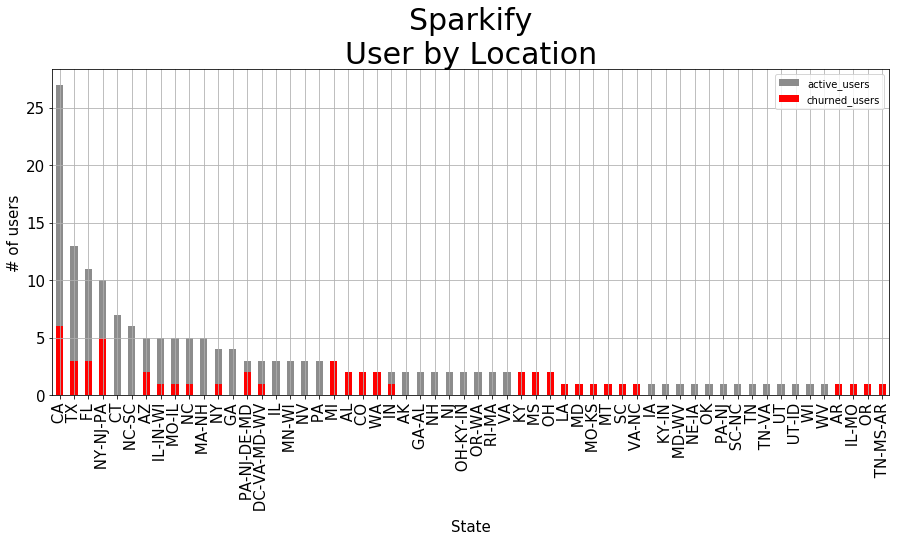

In [113]:
plt.title('Sparkify\nUser by Location', fontsize=30)

ax = location_by_state['active_users'].plot(kind='bar', \
                                               color ='0.55', figsize=(15, 6), legend=True, fontsize=15)

ax = location_by_state['churned_users'].plot(kind='bar', \
                                              color ='r', legend=True, fontsize=15)
ax.set_xlabel("State", fontsize=15)
ax.set_ylabel("# of users", fontsize=15)
plt.grid(True)
plt.show()

Most of Sparify's users are located in states with a large populations. In the small datatset, Sparify's churn rate inCa, TX and FL is below the overall churn rate of 52/125 or 42 percent. However, Spotify's churn rate in several of the less populated states in the country is high. 

Here is a list of the top ten most populated states in the country:

    CA - California (Population: 39,613,493)
    TX - Texas (Population: 29,730,311)
    FL - Florida (Population: 21,944,577)
    NY - New York (Population: 19,299,981)
    PA - Pennsylvania (Population: 12,804,123)
    IL - Illinois (Population: 12,569,321)
    OH - Ohio (Population: 11,714,618)
    GA - Georgia (Population: 10,830,007)
    NC - North Carolina (Population: 10,701,022)
    MI - Michigan (Population: 9,992,427)
          
USPS Abbreviation	
Alabama	        **AL**, Alaska **AK** , Arizona	**AZ** , Arkansas **AR** , California **CA** , 	Colorado **CO**	, Connecticut **CT** , Delaware	**DE**	, Florida **FL** , Georgia **GA** , Hawaii **HI** , Idaho **ID** , Illinois	**IL** , Indiana **IN**	, Iowa **IA** , Kansas **KS** , Kentucky **KY**	, Louisiana	**LA**	, Maine	**ME** , Maryland **MD** , Massachusetts	**MA** , Michigan **MI** , Minnesota **MN** , Mississippi **MS**, Missouri **MO** , Montana	**MT** , Nebraska **NE** , Nevada **NV** , 	New Hampshire **NH** , New Jersey **NJ** , New Mexico **NM** , New York	**NY**	, North Carolina	**NC** , North Dakota	**ND** , Ohio **OH** , Oklahoma	**OK** , Oregon	**OR** , Pennsylvania	**PA**	, Rhode Island	**RI**	, South Carolina	**SC**	 , 	South Dakota	**SD**, 	Tennessee **TN**	, Texas	**TX** , Utah	        **UT**	,  Vermont **VT** , Virginia **VA** , Washington **WA**	, West Virginia	**WV**, Wisconsin	**WI** , Wyoming **WY**	


https://worldpopulationreview.com/states

#### **`Page`** (string)

The categorical variable **`page`** shows the page on Sparkify's web-service that the user visited. There are 17 different pages on Sparkify's webpage.

In [114]:
page_count  = spark.sql('''
        SELECT page, Churn, COUNT(page) AS no_of_records
        FROM user_log_table
        GROUP BY Churn, page
        ORDER BY page DESC
        '''
        ).toPandas()

In [115]:
page_count_nochurn = page_count[page_count.Churn == 0]
page_count_nochurn = page_count_nochurn.rename(columns={"no_of_records": "active users"})
page_count_nochurn = page_count_nochurn.drop(['Churn'], axis=1)
page_count_nochurn = page_count_nochurn.set_index('page')   

page_count_churn = page_count[page_count.Churn == 1]
page_count_churn = page_count_churn.rename(columns={"no_of_records": "churned users"})
page_count_churn = page_count_churn.drop(['Churn'], axis=1)
page_count_churn = page_count_churn.set_index('page') 

df_page = pd.concat([page_count_nochurn, page_count_churn], axis=1, join="inner") 

In [116]:
df_page = df_page.sort_values(by=['active users', 'churned users'], ascending=True)

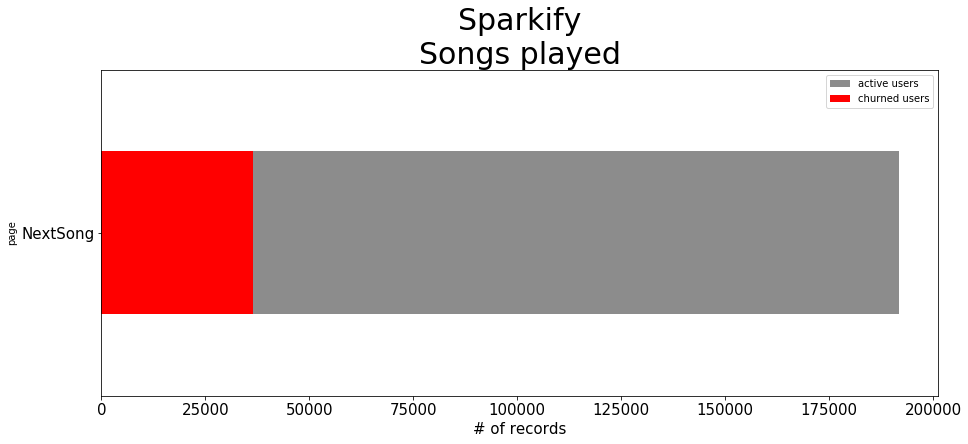

In [117]:
plt.title('Sparkify\nSongs played', fontsize=30)
plt.grid(True)
ax = df_page['active users'].tail(1).plot(kind='barh', color ='0.55', figsize=(15, 6), legend=True, fontsize=15)

ax = df_page['churned users'].tail(1).plot(kind='barh', \
                                              color ='r', legend=True, fontsize=15)
# ax.set_ylabel("Page", fontsize=15)
ax.set_xlabel("# of records", fontsize=15)
plt.grid(False)
plt.show()

How many songs do churned users play on average before they cancel the service?

In [118]:
# SELECT CASE WHEN 1 > 0 THEN 1 WHEN 2 > 0 THEN 2.0 ELSE 1.2 END;
is_confCancel = spark.sql('''
            SELECT userID, page, ts, CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END AS is_home 
            FROM user_log_table 
            WHERE ((page = 'NextSong') OR (page = 'Cancellation Confirmation')) AND Churn == 1
            '''
            )

# keep the results in a new view
is_confCancel.createOrReplaceTempView("is_confCancel_table")

# find the cumulative sum over the is_home column
cumulative_sum = spark.sql('''
            SELECT * , SUM(is_home) 
            OVER (PARTITION BY userID ORDER BY ts DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS period 
            FROM is_confCancel_table
            '''
            )
            

# keep the results in a view
cumulative_sum.createOrReplaceTempView("period_table")

# find the average count for NextSong
spark.sql('''
          SELECT INT(ROUND (AVG(count_results),0)) AS average_no_of_songs
          FROM (SELECT COUNT(*) AS count_results FROM period_table \
          GROUP BY userID, period, page HAVING page = 'NextSong') AS counts
          '''
          ).show()

+-------------------+
|average_no_of_songs|
+-------------------+
|                700|
+-------------------+



In [119]:
df_page = df_page.drop(index='NextSong').sort_values(by=['active users', 'churned users'], ascending=True)

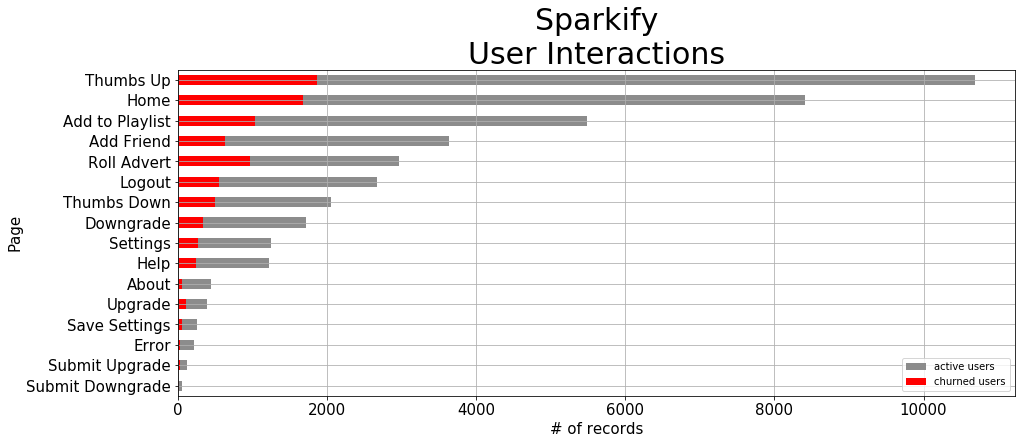

In [120]:
plt.title('Sparkify\nUser Interactions', fontsize=30)

ax = df_page['active users'].plot(kind='barh', color ='0.55', figsize=(15, 6), legend=True, fontsize=15)

ax = df_page['churned users'].plot(kind='barh', color ='r', legend=True, fontsize=15)
ax.set_ylabel("Page", fontsize=15)
ax.set_xlabel("# of records", fontsize=15)
plt.grid(True)
plt.show()

In [121]:
# Update temporary view
df_clean.createOrReplaceTempView("user_log_table")

In [122]:
df_statistics = spark.sql('''
      WITH page_counts AS( 
      SELECT userId, 
      MAX(Churn)                                                      AS Churn, 
      COUNT(CASE WHEN page = 'Thumbs Up'        THEN 1 ELSE null END) AS thumbs_up,
      COUNT(CASE WHEN page = 'Home'             THEN 1 ELSE null END) AS home,
      COUNT(CASE WHEN page = 'Add to Playlist'  THEN 1 ELSE null END) AS playlist_count, 
      COUNT(CASE WHEN page = 'Add Friend'       THEN 1 ELSE null END) AS friends,
      COUNT(CASE WHEN page = 'Roll Advert'      THEN 1 ELSE null END) AS advert,
      COUNT(CASE WHEN page = 'Logout'           THEN 1 ELSE null END) AS logout,
      COUNT(CASE WHEN page = 'Thumbs Down'      THEN 1 ELSE null END) AS thumbs_down,
      COUNT(CASE WHEN page = 'Downgrade'        THEN 1 ELSE null END) AS downgrade,
      COUNT(CASE WHEN page = 'Settings'         THEN 1 ELSE null END) AS settings,
      COUNT(CASE WHEN page = 'Help'             THEN 1 ELSE null END) AS help,
      COUNT(CASE WHEN page = 'About'            THEN 1 ELSE null END) AS about,
      COUNT(CASE WHEN page = 'Upgrade'          THEN 1 ELSE null END) AS upgrade,
      COUNT(CASE WHEN page = 'Save Settings'    THEN 1 ELSE null END) AS save_settings, 
      COUNT(CASE WHEN page = 'Error'            THEN 1 ELSE null END) AS error, 
      COUNT(CASE WHEN page = 'Submit Upgrade'   THEN 1 ELSE null END) AS submit_upgrade, 
      COUNT(CASE WHEN page = 'Submit Downgrade' THEN 1 ELSE null END) AS submit_downgrade,
      COUNT(DISTINCT sessionId)                                       AS session_count, 
      MAX (days_of_membership)                                        AS membership_days, 
      SUM(length/(60*60))                                             AS usage_hours 
      
      FROM user_log_table 
      GROUP BY userId) 
      SELECT Churn, 
      ROUND(AVG(thumbs_up),1)           AS thumbs_up,
      ROUND(AVG(home),1)                AS home,
      ROUND(AVG(playlist_count),1)      AS playlist_count, 
      ROUND(AVG(friends),1)             AS friends, 
      ROUND(AVG(advert),1)              AS advert, 
      ROUND(AVG(logout),1)              AS logout,
      ROUND(AVG(thumbs_down),1)         AS thumbs_down, 
      ROUND(AVG(downgrade),1)           AS downgrade, 
      ROUND(AVG(settings),1)            AS settings, 
      ROUND(AVG(help),1)                AS help, 
      ROUND(AVG(about),1)               AS about, 
      ROUND(AVG(upgrade),1)             AS upgrade,
      ROUND(AVG(save_settings),1)       AS save_settings,
      ROUND(AVG(error),1)               AS error, 
      ROUND(AVG(submit_upgrade),1)      AS submit_upgrade,
      ROUND(AVG(submit_downgrade),1)    AS submit_downgrade, 
      ROUND(AVG(session_count),1)       AS session_count,
      ROUND(AVG(membership_days),1)     AS membership_days,
      ROUND(AVG(usage_hours),1)         AS usage_hours
      
      FROM page_counts 
      GROUP BY Churn
      '''
      ).toPandas()

#df_statistics = df_statistics.set_index('Churn') 

In [123]:
df_statistics = df_statistics.set_index('Churn')

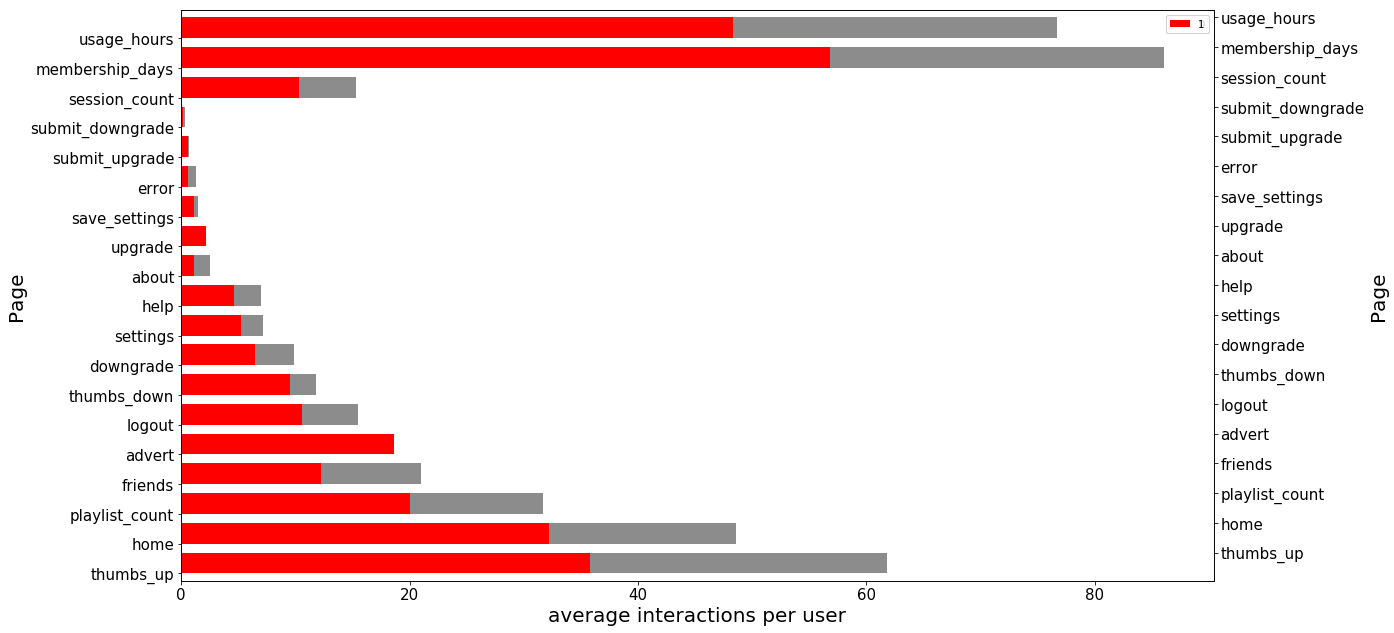

In [124]:
df = df_statistics[0:2].transpose()

fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.7

df[0].plot(kind='barh', color='0.55', ax=ax, width=width, position=0, legend=True, fontsize=15)
df[1].plot(kind='barh', color='red', ax=ax2, width=width, position=1, legend=True, fontsize=15)

ax.set_xlabel('average interactions per user', fontsize=20)
ax.set_ylabel('Page', fontsize=20)
ax2.set_ylabel('Page', fontsize=20)
fig.set_size_inches(18.5, 10.5)
plt.grid(False)
plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


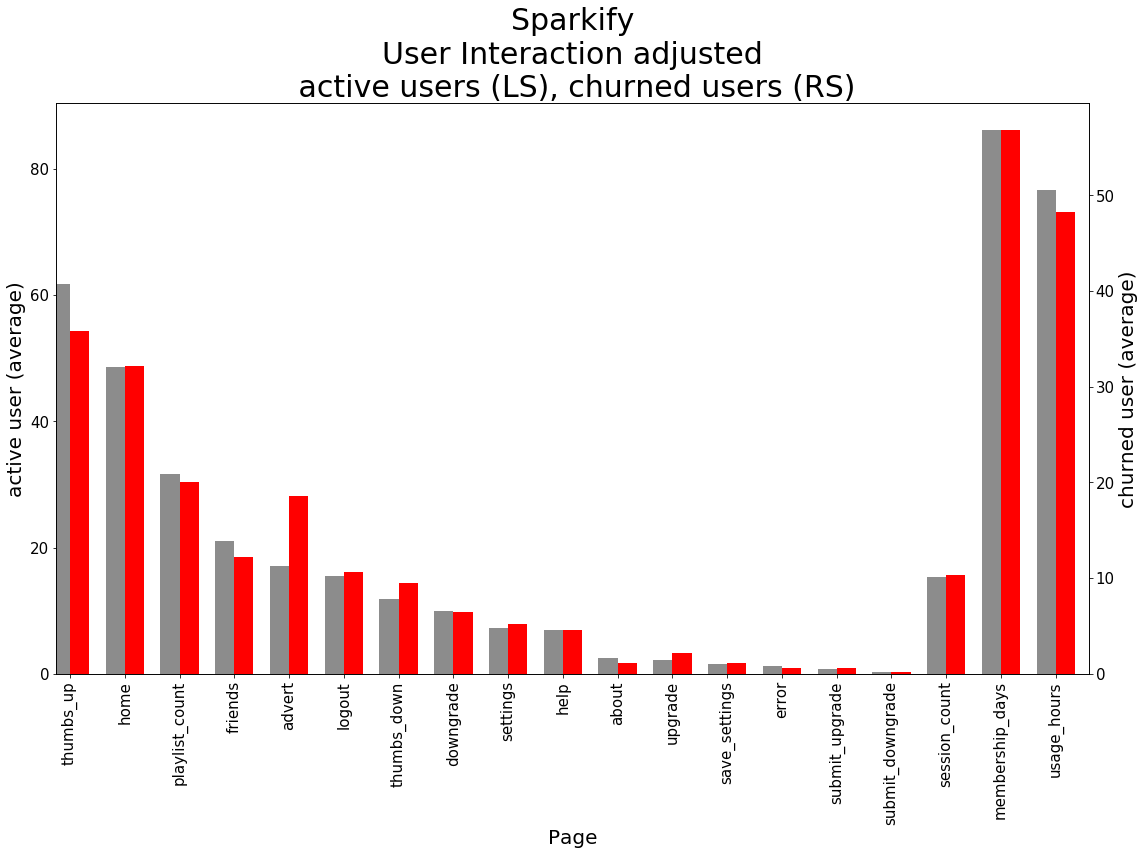

In [125]:

fig = plt.figure() # Create matplotlib figure
plt.title('Sparkify\nUser Interaction adjusted\n active users (LS), churned users (RS)', fontsize=30)
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.35

df[0].plot(kind='bar', color='0.55', ax=ax, width=width, position=1, legend=False, fontsize=15)
df[1].plot(kind='bar', color='red', ax=ax2, width=width, position=0, legend=False, fontsize=15)

ax.set_xlabel('Page', fontsize=20)
ax.set_ylabel('active user (average)', fontsize=20)
ax2.set_ylabel('churned user (average)', fontsize=20)
fig.set_size_inches(18.5, 10.5)
plt.grid(False)
plt.show()

Adjusting for days of membership and the number of sessions, we can identify behavior differences between active users and churned users.  

- Active users have more often visited the pages `thumbs_up`, `playlist_count` and  `friends`. 

- Churned users have more often visited the pages `advert`, `thumbs_down` and  `upgrade`.

In [126]:
df_statistics[0:2].transpose()

Churn,1,0
thumbs_up,35.8,61.8
home,32.2,48.6
playlist_count,20.0,31.7
friends,12.2,21.0
advert,18.6,17.1
logout,10.6,15.5
thumbs_down,9.5,11.8
downgrade,6.5,9.9
settings,5.2,7.2
help,4.6,7.0


In [127]:
# User Defined Function in Scala
spark.udf.register("get_hour", lambda x: int(datetime.datetime.fromtimestamp(x / 1000.0).hour))

<function __main__.<lambda>(x)>

In [128]:
df_clean.take(1)

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', timeanddate='2018-11-21 18:12:32', registration_timeanddate='2018-09-27 02:45:40', days_of_membership=55, churn_event=0, Churn=0, downgrade_event=0, phase=0, no_of_items=381, city='Bridgeport-Stamford-Norwalk', state=' CT')]

In [129]:
# We can use the UDF in the SQL querry

spark.sql('''
          SELECT *, get_hour(ts) AS hour
          FROM user_log_table 
          LIMIT 1
          '''
          ).collect()

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', timeanddate='2018-11-21 18:12:32', registration_timeanddate='2018-09-27 02:45:40', days_of_membership=55, churn_event=0, Churn=0, downgrade_event=0, phase=0, no_of_items=381, city='Bridgeport-Stamford-Norwalk', state=' CT', hour='18')]

In [130]:
songs_in_hour_active = spark.sql('''
          SELECT get_hour(ts) AS hour, COUNT(*) as active_users
          FROM user_log_table
          WHERE page = "NextSong" AND Churn = 0
          GROUP BY hour
          ORDER BY cast(hour as int) ASC
          '''
          ).toPandas()

In [131]:
songs_in_hour_churn  = spark.sql('''
          SELECT get_hour(ts) AS hour, COUNT(*) as churned_users
          FROM user_log_table
          WHERE page = "NextSong" AND Churn = 1
          GROUP BY hour
          ORDER BY cast(hour as int) ASC
          '''
          ).toPandas()

In [132]:
songs_in_hour_active  = songs_in_hour_active.set_index('hour')   
songs_in_hour_churn   = songs_in_hour_churn.set_index('hour')   

time_of_day = pd.concat([songs_in_hour_active, songs_in_hour_churn], axis=1, join="inner") 

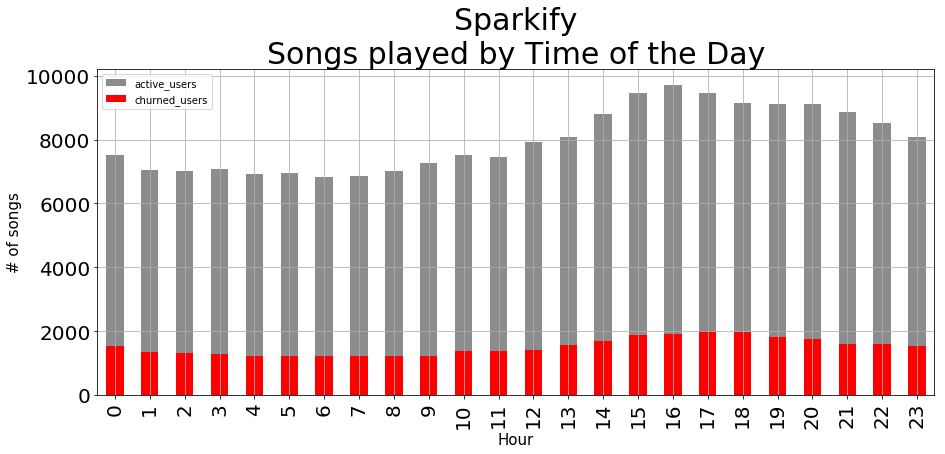

In [133]:
plt.title('Sparkify\nSongs played by Time of the Day', fontsize=30)

ax = time_of_day['active_users'].plot(kind='bar', \
                                                color ='0.55', figsize=(15, 6), legend=True, fontsize=25)

ax = time_of_day['churned_users'].plot(kind='bar', \
                                              color ='r', legend=True, fontsize=20)
ax.set_xlabel("Hour", fontsize=15)
ax.set_ylabel("# of songs", fontsize=15)
plt.grid(True)
plt.show()

Let us create new columns (i.e. variables) in the spark datatframe for time of day, day of the week, and for the weekday

#### New variable **`hour`** (string representing hour of the day) 

The variable shows the hour of the day of a record (i.e. user interaction).

#### New variable **`day`** (string representing day of the week) 

The variable shows the day of the month of a record (i.e. user interaction).

#### New variable **`weekday`** (string representing day of the week) 

The variable shows the weekday of a record (i.e. user interaction).

#### New variable **`date`** (string representing date) 

The variable shows the date of a record (i.e. user interaction).

In [134]:
# User Defined Functions


get_hourOfDay  = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)

# Day of the month as a zero-padded decimal number.
get_dayOfMonth = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)

# Weekday as a decimal number, where 0 is Sunday and 6 is Saturday.
# https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
get_weekday    = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))
get_date       = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%m/%d/%Y')) 

In [135]:
# Create new columns
df_clean = df_clean.withColumn('hour', get_hourOfDay(df_clean.ts))
df_clean = df_clean.withColumn('day', get_dayOfMonth(df_clean.ts))
df_clean = df_clean.withColumn('weekday', get_weekday(df_clean.ts))
df_clean = df_clean.withColumn('date', get_date(df_clean.ts))

In [136]:
df_clean.take(1)

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', timeanddate='2018-11-21 18:12:32', registration_timeanddate='2018-09-27 02:45:40', days_of_membership=55, churn_event=0, Churn=0, downgrade_event=0, phase=0, no_of_items=381, city='Bridgeport-Stamford-Norwalk', state=' CT', hour='18', day='21', weekday='3', date='11/21/2018')]

In [137]:
df_clean.createOrReplaceTempView("user_log_table")

In [138]:
df_dayOfWeek_active = spark.sql('''
          SELECT day AS dayOfMonth, COUNT(*) as active_users
          FROM user_log_table
          WHERE Churn == 0
          GROUP BY dayOfMonth
          ORDER BY cast(day as int) ASC
          
          '''
          ).toPandas()

In [139]:
df_dayOfWeek_churn = spark.sql('''
          SELECT day AS dayOfMonth, COUNT(*) as churned_users
          FROM user_log_table
          WHERE Churn == 1
          GROUP BY dayOfMonth
          ORDER BY cast(day as int) ASC
          
          '''
          ).toPandas()

In [140]:
df_dayOfWeek_active  = df_dayOfWeek_active.set_index('dayOfMonth')   
df_dayOfWeek_churn   = df_dayOfWeek_churn.set_index('dayOfMonth')   

df_dayOfWeek = pd.concat([df_dayOfWeek_active, df_dayOfWeek_churn], axis=1, join="outer") 

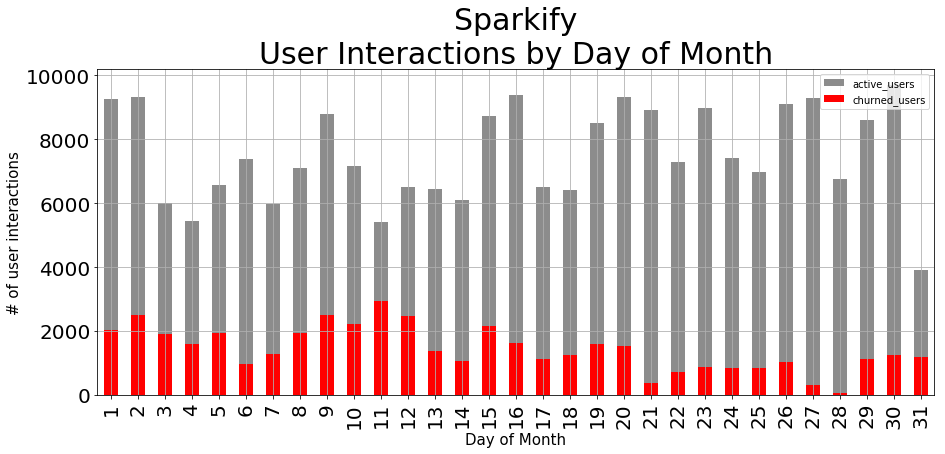

In [141]:
plt.title('Sparkify\nUser Interactions by Day of Month', fontsize=30)

ax = df_dayOfWeek['active_users'].plot(kind='bar', \
                                                color ='0.55', figsize=(15, 6), legend=True, fontsize=25)

ax = df_dayOfWeek['churned_users'].plot(kind='bar', \
                                              color ='r', legend=True, fontsize=20)
ax.set_xlabel("Day of Month", fontsize=15)
ax.set_ylabel("# of user interactions", fontsize=15)
plt.grid(True)
plt.show()

In [142]:
df_weekday_active = spark.sql('''
          SELECT weekday , COUNT(*) as active_user
          FROM user_log_table
          WHERE Churn == 0
          GROUP BY weekday
          ORDER BY cast(weekday as int) ASC
          
          '''
          ).toPandas()

In [143]:
df_weekday_churn = spark.sql('''
          SELECT weekday , COUNT(*) as churned_user
          FROM user_log_table
          WHERE Churn == 1
          GROUP BY weekday
          ORDER BY cast(weekday as int) ASC
          
          '''
          ).toPandas()

In [144]:
df_weekday_active  = df_weekday_active.set_index('weekday')   
df_weekday_churn   = df_weekday_churn.set_index('weekday')   

df_weekday = pd.concat([df_weekday_active, df_weekday_churn], axis=1, join="outer") 

In [145]:
# Weekday as a decimal number, where 0 is Sunday and 6 is Saturday.
map_dict = {'0':'Sunday','1':'Monday','2':'Tuesday','3':'Wednesday','4':'Thursday','5':'Friday','6':'Saturday'}
df_weekday.index = df_weekday.index.map(map_dict)


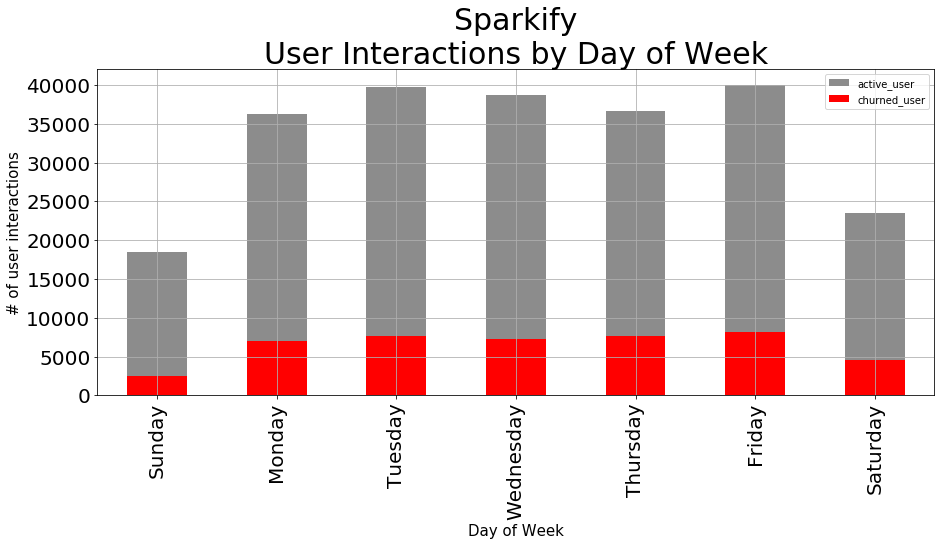

In [146]:
plt.title('Sparkify\nUser Interactions by Day of Week', fontsize=30)

ax = df_weekday['active_user'].plot(kind='bar', color ='0.55', figsize=(15, 6), legend=True, fontsize=20)
ax = df_weekday['churned_user'].plot(kind='bar', color ='r', legend=True, fontsize=20)
ax.set_xlabel("Day of Week", fontsize=15)
ax.set_ylabel("# of user interactions", fontsize=15)
plt.grid(True)
plt.show()

In [147]:
df_clean.createOrReplaceTempView("user_log_table")

In [148]:
df_date_active = spark.sql('''
          SELECT date , COUNT(*) as active_user
          FROM user_log_table
          WHERE Churn == 0
          GROUP BY date
          ORDER BY cast(date as int) DESC
          
          '''
          ).toPandas()

In [149]:
df_date_churn = spark.sql('''
          SELECT date , COUNT(*) as churned_user
          FROM user_log_table
          WHERE Churn == 1
          GROUP BY date
          ORDER BY cast(date as int) DESC
          
          '''
          ).toPandas()

In [150]:
df_date_active = df_date_active.set_index('date')   
df_date_churn   = df_date_churn.set_index('date')   

df_date = pd.concat([df_date_active, df_date_churn], axis=1, join="outer", sort=True) 

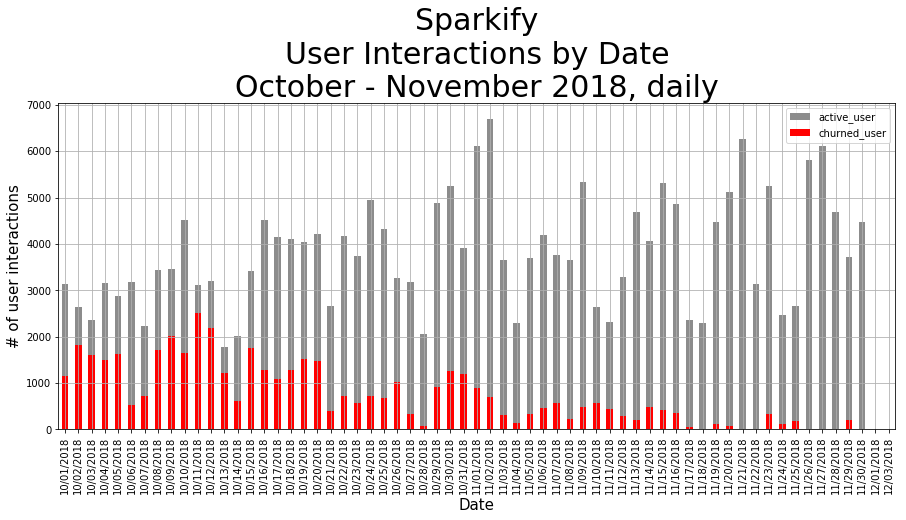

In [151]:
plt.title('Sparkify\nUser Interactions by Date\nOctober - November 2018, daily', fontsize=30)

ax = df_date['active_user'].plot(kind='bar', color ='0.55', figsize=(15, 6), legend=True, fontsize=20)

ax = df_date['churned_user'].plot(kind='bar', color ='r', legend=True, fontsize=10)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel("# of user interactions", fontsize=15)
plt.grid(True)
plt.show()

#### New variable **`Cohort`**

Cohort analysis

    Cohort analysis is a kind of behavioral analytics that breaks the data in a data set into related groups before analysis. These groups, or cohorts, usually share common characteristics or experiences within a defined time-span.Cohort analysis allows a company to "see patterns clearly across the life-cycle of a customer (or user), rather than slicing across all customers blindly without accounting for the natural cycle that a customer undergoes." By seeing these patterns of time, a company can adapt and tailor its service to those specific cohorts. While cohort analysis is sometimes associated with a cohort study, they are different and should not be viewed as one and the same. Cohort analysis is specifically the analysis of cohorts in regards to big data and business analytics, while in cohort study, data is broken down into similar groups. 
    
    https://en.wikipedia.org/wiki/Cohort_analysis

In [152]:
# Let us define a new variable `cohort`
get_cohort = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%m/%Y')) 
df_clean   = df_clean.withColumn('cohort', get_cohort(df_clean.registration))


In [153]:
df_clean.take(1)

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', timeanddate='2018-11-21 18:12:32', registration_timeanddate='2018-09-27 02:45:40', days_of_membership=55, churn_event=0, Churn=0, downgrade_event=0, phase=0, no_of_items=381, city='Bridgeport-Stamford-Norwalk', state=' CT', hour='18', day='21', weekday='3', date='11/21/2018', cohort='09/2018')]

In [154]:
df_clean.createOrReplaceTempView("user_log_table")

In [155]:
df_cohort_active = spark.sql('''
          SELECT cohort , COUNT(DISTINCT UserId) as active_users
          FROM user_log_table
          WHERE Churn == 0
          GROUP BY cohort
          ORDER BY cohort DESC
          
          '''
          ).toPandas()

In [156]:
df_cohort_churn = spark.sql('''
          SELECT cohort , COUNT(DISTINCT UserId) as churned_user
          FROM user_log_table
          WHERE Churn == 1
          GROUP BY cohort
          ORDER BY cohort DESC
          
          '''
          ).toPandas()

In [157]:
df_cohort_active = df_cohort_active.set_index('cohort')   
df_cohort_churn   = df_cohort_churn.set_index('cohort')   

df_cohort = pd.concat([df_cohort_active, df_cohort_churn], axis=1, join="outer", sort=True) 

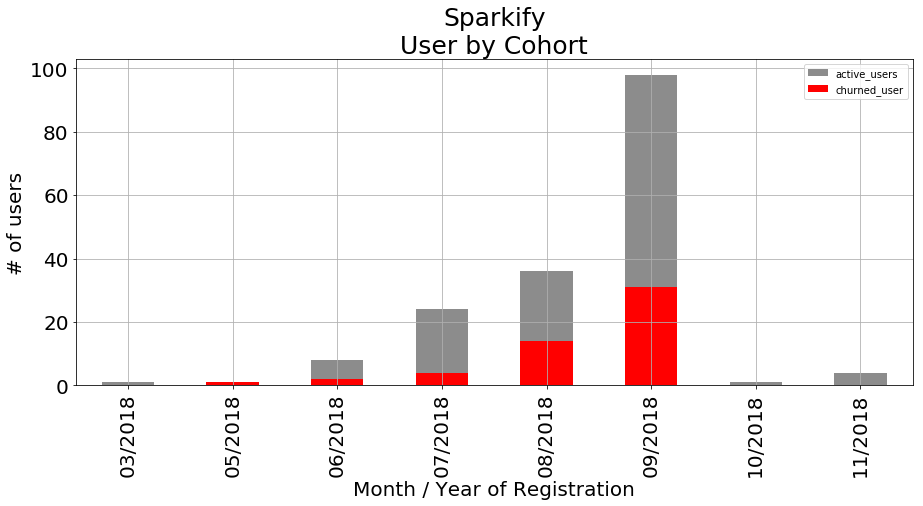

In [158]:
plt.title('Sparkify\nUser by Cohort', fontsize=25)
ax = df_cohort['active_users'].plot(kind='bar', color ='0.55', figsize=(15, 6), legend=True, fontsize=20)

ax = df_cohort['churned_user'].plot(kind='bar', color ='r', legend=True, fontsize=20)
ax.set_xlabel("Month / Year of Registration", fontsize=20)
ax.set_ylabel("# of users", fontsize=20)
plt.grid(True)
plt.show()

Most users in this dataset belong to the cohorts 07/2018 , 08/2018 and 09/2018. 

#### **`User-Agent`** (string)

    The User-Agent request header is a characteristic string that lets servers and network peers identify the 
    application, operating system, vendor, and/or version of the requesting user agent.

    https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers/User-Agent
    
##### Mobile, Tablet or Desktop

    The most common reason to perform user agent sniffing is to determine which type of device the browser runs on. 
    The goal is to serve different HTML to different device types.

    Never assume that a browser or a rendering engine only runs on one type of device. Especially don't make 
    different defaults for different browsers or rendering engines. Never use the OS token to define if a browser is 
    on mobile, tablet or desktop. The OS may run on more than one type of (for example, Android runs on tablets as well 
    as phones).
    
    In summary, we recommend looking for the string “Mobi” anywhere in the User Agent to detect a mobile device.
    
    If the device is large enough that it's not marked with “Mobi”, you should serve your desktop site 
    (which, as a best practice, should support touch input anyway, as more desktop machines are appearing with
    touchscreens).
    
    https://developer.mozilla.org/en-US/docs/Web/HTTP/Browser_detection_using_the_user_agent



In [159]:
userAgent_count = spark.sql('''
        SELECT userAgent,COUNT(userId) AS no_of_records
        FROM user_log_table
        GROUP BY userAgent
        ORDER BY no_of_records DESC
''').toPandas()

In [160]:
userAgent_count.head()

,userAgent,no_of_records
0,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",22751
1,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",19611
2,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18448
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",17348
4,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,16700


In [161]:
# Show the entire lenth of the most common userAgent
userAgent_count.iloc[27,0]

'Mozilla/5.0 (X11; Linux x86_64; rv:31.0) Gecko/20100101 Firefox/31.0'

#### New variable **`mobile`** (Integer: 1 = true or 0=false)

The browser runs on a mobile device (e.g. iPhone, iPad).

#### New variable **`Apple_Mac`** (Integer: 1 = true or 0=false)

The browser runs on an Apple PC or Apple notebook.

#### New variable **`Linux_Ubuntu`** (Integer: 1 = true or 0=false)

The browser runs on an a Linux PC or Linux notebook with an Ubuntu operating system.

#### New variable **`Windows`** (Integer: 1 = true or 0=false)

The browser runs on an a Windows PC or Windows notebook with a Microsoft operating system. 

In [162]:
flag_mobile          = udf(lambda x: 1 if 'Mobi' in x else 0, IntegerType())
df_clean             = df_clean.withColumn("mobile", flag_mobile(df_clean.userAgent))

flag_Apple_Mac       = udf(lambda x: 1 if 'Mac' in x and not 'Mobi' in x else 0, IntegerType())
df_clean             = df_clean.withColumn("Apple_Mac", flag_Apple_Mac(df_clean.userAgent))

flag_Ubuntu           = udf(lambda x: 1 if 'Ubuntu' in x or 'Linux' in x and not 'Mobi' in x else 0, IntegerType())
df_clean             = df_clean.withColumn("Linux_Ubuntu", flag_Ubuntu(df_clean.userAgent))

flag_Windows         = udf(lambda x: 1 if 'Windows' in x and not 'Mobi' in x and not 'Ubuntu' in x else 0, IntegerType())
df_clean             = df_clean.withColumn("Windows", flag_Windows(df_clean.userAgent))        


In [163]:
df_clean.createOrReplaceTempView("user_log_table")

In [164]:
df_mobile = spark.sql('''
          SELECT COUNT(DISTINCT userId) AS mobile, Churn
          FROM user_log_table
          WHERE mobile == 1
          GROUP BY Churn
          
          '''
          ).toPandas()

df_mobile.set_index('Churn', inplace = True)


In [165]:
df_Apple_Mac = spark.sql('''
          SELECT COUNT(DISTINCT userId) AS Apple_Mac, Churn
          FROM user_log_table
          WHERE Apple_Mac == 1
          GROUP BY Churn
          
          '''
          ).toPandas()

df_Apple_Mac.set_index('Churn', inplace = True)


In [166]:
df_Linux = spark.sql('''
          SELECT COUNT(DISTINCT userId) AS Linux, Churn
          FROM user_log_table
          WHERE Linux_Ubuntu == 1
          GROUP BY Churn
          
          '''
          ).toPandas()

df_Linux.set_index('Churn', inplace = True)


In [167]:
df_Windows = spark.sql('''
          SELECT COUNT(DISTINCT userId) AS Windows, Churn
          FROM user_log_table
          WHERE Windows == 1
          GROUP BY Churn
           
          '''
          ).toPandas()

df_Windows.set_index('Churn', inplace = True)


In [168]:
df_platform = pd.concat([df_mobile, df_Apple_Mac, df_Linux, df_Windows], axis=1, join="inner")

In [169]:
map_dict_churn    = {0:'Active Users',1:'Churned Users'}
df_platform.index = df_platform.index.map(map_dict_churn)

In [170]:
df_platform

,mobile,Apple_Mac,Linux,Windows
Churn,,,,
Churned Users,4,19,5,24
Active Users,12,67,7,87


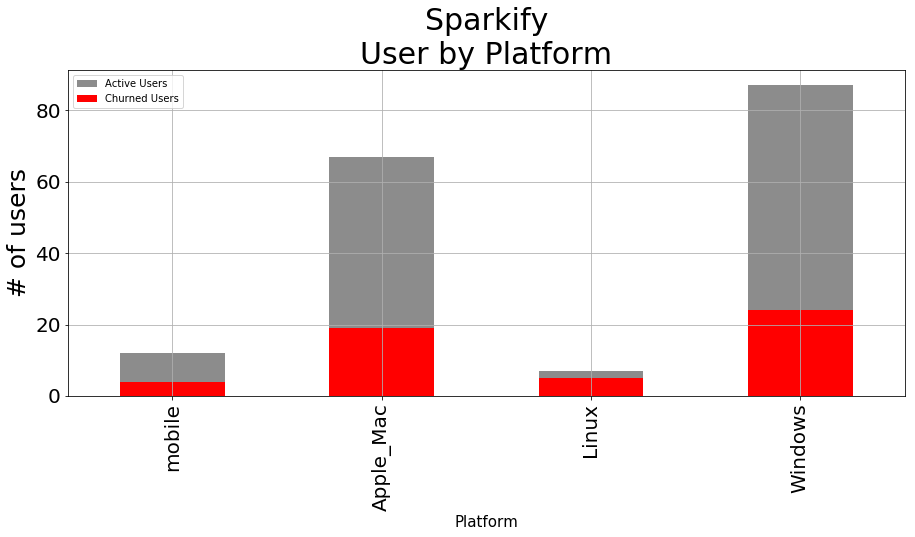

In [171]:

plt.title('Sparkify\nUser by Platform', fontsize=30)
ax = df_platform.iloc[1].plot(kind='bar', color ='0.55', figsize=(15, 6), legend=True, fontsize=25)
ax = df_platform.iloc[0].plot(kind='bar', color ='r', legend=True, fontsize=20)
ax.set_xlabel("Platform", fontsize=15)
ax.set_ylabel("# of users", fontsize=25)
plt.grid(True)
plt.show()

Most users operate Sparkify on desktop or laptop computers. 

In [172]:
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- timeanddate: string (nullable = true)
 |-- registration_timeanddate: string (nullable = true)
 |-- days_of_membership: integer (nullable = true)
 |-- churn_event: integer (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- downgrade_event: integer (nullable = true)
 |-- phase: long (nullable

In [173]:
df_clean.take(1)

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', timeanddate='2018-11-21 18:12:32', registration_timeanddate='2018-09-27 02:45:40', days_of_membership=55, churn_event=0, Churn=0, downgrade_event=0, phase=0, no_of_items=381, city='Bridgeport-Stamford-Norwalk', state=' CT', hour='18', day='21', weekday='3', date='11/21/2018', cohort='09/2018', mobile=1, Apple_Mac=0, Linux_Ubuntu=0, Windows=0)]

In PySpark, we can cast or change the DataFrame column data type using the cast() function.  

In [174]:
df_clean = df_clean.withColumn("hour", df_clean["hour"].cast(IntegerType()))

df_clean = df_clean.withColumn("day", df_clean["day"].cast(IntegerType()))

df_clean = df_clean.withColumn("weekday", df_clean["weekday"].cast(IntegerType()))

df_clean = df_clean.withColumn("userId", df_clean["userId"].cast(IntegerType()))

In [175]:
df_clean.createOrReplaceTempView("user_log_table")

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [176]:

Feat_Engr = spark.sql(
      '''
      SELECT userId, 
      MAX(Churn)                                                      AS label, 
      COUNT(CASE WHEN page = 'Error'            THEN 1 ELSE null END) AS error_count, 
      COUNT(CASE WHEN page = 'Add Friend'       THEN 1 ELSE null END) AS friends_count, 
      COUNT(CASE when page = 'Roll Advert'      THEN 1 ELSE null END) AS advert_count,
      COUNT(CASE WHEN page = 'Add to Playlist'  THEN 1 ELSE null END) AS playlist_count, 
      COUNT(CASE WHEN page = 'Thumbs Up'        THEN 1 ELSE null END) AS thumbs_up, 
      COUNT(CASE WHEN page = 'Thumbs Down'      THEN 1 ELSE null END) AS thumbs_down, 
      COUNT(CASE WHEN page = 'Downgrade'        THEN 1 ELSE null END) AS downgrade,
      COUNT(CASE WHEN page = 'Upgrade'          THEN 1 ELSE null END) AS upgrade,
      COUNT(CASE WHEN page = 'Submit Upgrade'   THEN 1 ELSE null END) AS submit_upgrade, 
      COUNT(CASE WHEN page = 'Submit Downgrade' THEN 1 ELSE null END) AS submit_downgrade,
      
      INT  (Case WHEN FIRST (level) ='free' THEN True ELSE False END) AS FIRST_level_free,
      INT  (Case WHEN FIRST (level) ='paid' THEN True ELSE False END) AS FIRST_level_paid,
      INT  (Case WHEN LAST (level)  ='free' THEN True ELSE False END) AS LAST_level_free,
      INT  (Case WHEN LAST (level)  ='paid' THEN True ELSE False END) AS LAST_level_paid,
    
      
      SUM(downgrade_event)                                            AS phase,
      MAX(mobile)                                                     AS mobile,
      MAX(Apple_Mac)                                                  AS Apple_Mac,
      MAX(Linux_Ubuntu)                                               AS Linux,
      MAX(Windows)                                                    AS Windows,
      AVG(hour)                                                       AS hour,
      AVG(day)                                                        AS day,
      AVG(weekday)                                                    AS weekday,
      
      INT(MAX(CASE WHEN cohort = '05/2018' THEN True ELSE False END))   AS cohort_May18,
      INT(MAX(CASE WHEN cohort = '06/2018' THEN True ELSE False END))   AS cohort_Jun18,
      INT(MAX(CASE WHEN cohort = '07/2018' THEN True ELSE False END))   AS cohort_Jul18,
      INT(MAX(CASE WHEN cohort = '08/2018' THEN True ELSE False END))   AS cohort_Aug18,
      INT(MAX(CASE WHEN cohort = '09/2018' THEN True ELSE False END))   AS cohort_Sep18,
      INT(MAX(CASE WHEN gender = 'F' THEN True ELSE False END))         AS female,
      INT(MAX(CASE WHEN state  = ' CA'       THEN True ELSE False END)) AS CA,
      INT(MAX(CASE WHEN state  = ' TX'       THEN True ELSE False END)) AS TX,
      INT(MAX(CASE WHEN state  = ' FL'       THEN True ELSE False END)) AS FL,
      INT(MAX(CASE WHEN state  = ' NY-NJ-PA' THEN True ELSE False END)) AS NY_NJ_PA,
      
      MAX (days_of_membership)                                          AS membership_days, 
      COUNT(DISTINCT sessionId)                                         AS session_count,
      MAX(no_of_items)                                                  AS items_count,   
      COUNT(CASE WHEN page = 'NextSong'         THEN 1 ELSE null END)   AS song_count, 
      SUM(length/(60*60))                                               AS usage_hours
      
      FROM user_log_table 
      GROUP BY userId
      '''
      )


In [177]:
Feat_Engr.createOrReplaceTempView('Feat_Engr');
Feat_Engr=Feat_Engr.na.drop()

In [178]:
df_Feat_Engr = Feat_Engr.toPandas()

In [179]:
df_Feat_Engr.transpose()

,0,1,2,3,4,5,6,7,8,9,...,215,216,217,218,219,220,221,222,223,224
userId,148.000000,85.000000,137.000000,65.000000,200001.000000,53.000000,133.000000,100003.000000,200021.000000,78.000000,...,18.000000,74.000000,138.000000,200005.000000,104.000000,134.000000,36.000000,200002.000000,89.000000,300022.000000
label,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
error_count,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
friends_count,7.000000,58.000000,8.000000,53.000000,0.000000,25.000000,1.000000,0.000000,19.000000,2.000000,...,10.000000,43.000000,41.000000,3.000000,23.000000,0.000000,35.000000,4.000000,14.000000,11.000000
advert_count,32.000000,33.000000,10.000000,8.000000,3.000000,25.000000,1.000000,9.000000,11.000000,16.000000,...,0.000000,22.000000,17.000000,5.000000,23.000000,3.000000,34.000000,7.000000,13.000000,0.000000
playlist_count,5.000000,108.000000,4.000000,68.000000,3.000000,46.000000,3.000000,2.000000,30.000000,9.000000,...,14.000000,80.000000,67.000000,5.000000,43.000000,2.000000,23.000000,8.000000,12.000000,9.000000
thumbs_up,28.000000,192.000000,8.000000,111.000000,10.000000,69.000000,2.000000,3.000000,55.000000,11.000000,...,20.000000,135.000000,95.000000,7.000000,84.000000,3.000000,53.000000,21.000000,30.000000,25.000000
thumbs_down,3.000000,38.000000,1.000000,17.000000,1.000000,16.000000,0.000000,0.000000,35.000000,3.000000,...,1.000000,25.000000,24.000000,0.000000,17.000000,1.000000,12.000000,6.000000,6.000000,5.000000
downgrade,0.000000,42.000000,0.000000,20.000000,0.000000,13.000000,0.000000,0.000000,26.000000,0.000000,...,3.000000,31.000000,21.000000,0.000000,24.000000,0.000000,3.000000,5.000000,2.000000,1.000000
upgrade,3.000000,7.000000,4.000000,3.000000,1.000000,5.000000,0.000000,0.000000,3.000000,1.000000,...,0.000000,3.000000,1.000000,2.000000,3.000000,1.000000,7.000000,2.000000,2.000000,0.000000


In [180]:
df_Feat_Engr.describe()

,userId,label,error_count,friends_count,advert_count,playlist_count,thumbs_up,thumbs_down,downgrade,upgrade,...,female,CA,TX,FL,NY_NJ_PA,membership_days,session_count,items_count,song_count,usage_hours
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,...,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,65391.013333,0.231111,1.120000,19.008889,17.480000,29.004444,55.782222,11.315556,9.133333,2.217778,...,0.462222,0.146667,0.071111,0.062222,0.066667,79.364444,14.115556,1236.240000,1013.813333,70.155089
std,105396.477919,0.422483,1.472607,20.581717,21.550207,32.716654,65.477925,13.077481,11.734412,2.558537,...,0.499682,0.354562,0.257583,0.242097,0.250000,37.646625,14.646885,1329.531716,1104.960779,76.499001
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,3.000000,0.192130
25%,60.000000,0.000000,0.000000,5.000000,3.000000,6.000000,11.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,59.000000,6.000000,296.000000,230.000000,16.009215
50%,116.000000,0.000000,1.000000,14.000000,11.000000,17.000000,35.000000,7.000000,5.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000,10.000000,848.000000,675.000000,46.692719
75%,100017.000000,0.000000,2.000000,27.000000,22.000000,44.000000,81.000000,16.000000,13.000000,3.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,100.000000,18.000000,1863.000000,1571.000000,109.000415
max,300025.000000,1.000000,7.000000,143.000000,128.000000,240.000000,437.000000,75.000000,73.000000,15.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,256.000000,107.000000,9632.000000,8002.000000,553.098588


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

#### Step 1. Train Test Split

As a first step we break our data set into 80% of training data and set aside 20%. Set random seed to 42.

In [181]:
rest, validation = Feat_Engr.randomSplit([0.8, 0.2], seed=42)

In [182]:
validation.count()

45

#### Step 2. Create a Feature Vector

Create a vector from the combined columns of all of the features.

    VectorAssembler is a transformer that combines a given list of columns into a single vector column. It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models like logistic regression and decision trees. VectorAssembler accepts the following input column types: 
    all numeric types, boolean type, and vector type. In each row, the values of the input columns will be concatenated into a vector in the specified order.
    https://spark.apache.org/docs/1.4.1/ml-features.html

In [183]:

assembler = VectorAssembler(inputCols=["userId",
                                       "error_count",
                                       "friends_count",
                                       "advert_count",
                                       "playlist_count", 
                                       "thumbs_up",
                                       "thumbs_down",
                                       "downgrade", 
                                       "upgrade",
                                       "submit_upgrade",
                                       "submit_downgrade", 
                                       "FIRST_level_paid",
                                       "LAST_level_paid",
                                       "phase", 
                                       "mobile", 
                                       "Apple_Mac", 
                                       "Linux", 
                                       "Windows", 
                                       "hour", 
                                       "day", 
                                       "weekday", 
                                       "cohort_May18", 
                                       "cohort_Jun18", 
                                       "cohort_Jul18", 
                                       "cohort_Aug18", 
                                       "cohort_Sep18", 
                                       "female", 
                                       "CA", 
                                       "TX", 
                                       "FL", 
                                       "NY_NJ_PA", 
                                       "membership_days",
                                       "session_count",
                                       "items_count",
                                       "song_count",
                                       "usage_hours"],
                            
                            outputCol="inputFeatures")


#### Step 3.  Normalize the Vectors

    Normalizer is a Transformer which transforms a dataset of Vector rows, normalizing each Vector to have unit norm. 
    It takes parameter p, which specifies the p-norm used for normalization. (p=2 by default.) 
    This normalization can help standardize your input data and improve the behavior of learning algorithms.
    https://spark.apache.org/docs/1.4.1/ml-features.html

In [184]:
scaler = Normalizer(inputCol="inputFeatures", outputCol="features")

#### Step 4. Build Pipelines

Spark supports 9 algorithms for Classification:
    https://spark.apache.org/docs/latest/ml-classification-regression.html#classification

    - Logistic regression
        Binomial logistic regression
        Multinomial logistic regression
    - Decision tree classifier
    - Random forest classifier
    - Gradient-boosted tree classifier
    - Multilayer perceptron classifier
    - Linear Support Vector Machine
    - One-vs-Rest classifier (a.k.a. One-vs-All)
    - Naive Bayes
    - Factorization machines classifier

Let us choose 4 of those algorithms:

In [185]:
# Logistic regression
lr           =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
pipeline_lr  = Pipeline(stages=[assembler, scaler, lr ])

# Random forest classifier
rf           = RandomForestClassifier() 
pipeline_rf  = Pipeline(stages=[assembler, scaler, rf])

# Gradient-boosted tree classifier
gbt          = GBTClassifier() 
pipeline_gbt = Pipeline(stages=[assembler, scaler, gbt])

# Linear Support Vector Machine
svm          = LinearSVC()
pipeline_svm = Pipeline(stages=[assembler, scaler, svm])


### Logistic Regression Model

#### Tune Model

On the first 80% of the data let's find the most accurate logistic regression model using 3-fold cross-validation with the following parameter grid:

- LogisticRegression regularization parameter: [0.0, 0.1]
- LogisticRegression max Iteration number: [10]

    
#### Cross validation    
    K-fold cross validation performs model selection by splitting the dataset into a set of non-overlapping 
    randomly partitioned folds which are used as separate training and test datasets e.g., with k=3 folds, 
    K-fold cross validation will generate 3 (training, test) dataset pairs, 
    each of which uses 2/3 of the data for training and 1/3 for testing. 
    Each fold is used as the test set exactly once.
    https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html
    
#### F-score
    In statistical analysis of binary classification, the F-score or F-measure is a measure of a test's accuracy. 
    It is calculated from the precision and recall of the test, where 
    - the precision is the number of true positive results divided by the number of all positive results, 
      including those not identified correctly, and 
    - the recall is the number of true positive results divided by the number of all samples that should have been 
      identified as positive. 
    - Precision is also known as positive predictive value, and recall is also known as sensitivity 
      in diagnostic binary classification. 
    - The F1 score is the harmonic mean of the precision and recall. 
    https://en.wikipedia.org/wiki/F-score

In [186]:
paramgrid =ParamGridBuilder()\
.addGrid(lr.regParam, [0.0, 0,1])\
.addGrid(lr.maxIter, [10])\
.build()


evaluator=MulticlassClassificationEvaluator(metricName="f1")

crossval= CrossValidator(estimator=pipeline_lr,  
                         estimatorParamMaps=paramgrid,
                         evaluator = evaluator , 
                         numFolds=3
                        )


In [187]:
start = time.time()

# Fit the logistic regression cross validation model
cvModel_ls = crossval.fit(rest)

end = time.time()
print(f'Model fitting took {end-start} seconds')

Model fitting took 614.5652391910553 seconds


In [188]:
cvModel_ls.avgMetrics

[0.6410839793099525, 0.6410839793099525, 0.6554890814952734]

In [189]:
results_ls = cvModel_ls.transform(validation)

#### Compute Accuracy of  Best Logistic Regression Model

    Accuracy is one metric for evaluating classification models. Informally, accuracy is the fraction of predictions our model got right. Formally, accuracy has the following definition:
    
    Accuracy = Number of Correct Predictions / Total Number of Predictions
    
    For binary classification, accuracy can also be calculated in terms of positives and negatives as follows:
    
    Accuracy = ( TP + TN ) / ( TP + TN + FP + FN )
    
    Where TP = True Positives, TN = True Negatives, FP = False Positives, and FN = False Negatives
    https://developers.google.com/machine-learning/crash-course/classification/accuracy

In [190]:
ls_TP = (results_ls.filter(results_ls.label == results_ls.prediction).count())
ls_totalNoPredictions = (results_ls.count())

print(ls_TP,' Number of Correct Predictions.')
print(ls_totalNoPredictions, ' Total Number of Predictions.')
print(ls_TP/ls_totalNoPredictions, ' Accuracy.')


36  Number of Correct Predictions.
45  Total Number of Predictions.
0.8  Acuracy.


#### Evaluate model based on F1 score

The F1 score is the harmonic mean of the precision and recall. 

In [193]:
evaluator.evaluate(cvModel_ls.transform(validation))

0.7295742232451093

### Random forest classifier

#### Tune Model

In [194]:
paramgrid_rf = ParamGridBuilder()\
.build()

evaluator=MulticlassClassificationEvaluator(metricName="f1")

crossval= CrossValidator(estimator=pipeline_rf,  
                         estimatorParamMaps=paramgrid_rf,
                         evaluator=evaluator, 
                         numFolds=3
                        )


In [195]:
start = time.time()

# Fit the random forest cross validation model
cvModel_rf = crossval.fit(rest)

end = time.time()
print(f'Model fitting took {end-start} seconds')

Model fitting took 526.0161521434784 seconds


In [196]:
results_rf = cvModel_rf.transform(validation)

#### Compute Accuracy of  Random Forest Model

In [198]:
rf_TP = (results_rf.filter(results_rf.label == results_rf.prediction).count())
rf_totalNoPredictions = (results_rf.count())

print(rf_TP,' Number of Correct Predictions.')
print(rf_totalNoPredictions, ' Total Number of Predictions.')
print(rf_TP/rf_totalNoPredictions, ' Accuracy.')


33  Number of Correct Predictions.
45  Total Number of Predictions.
0.7333333333333333  Acuracy.


#### Evaluate model based on F1 score

In [199]:
evaluator.evaluate(cvModel_rf.transform(validation))

0.6867167919799498

### Gradient-boosted Tree classifier

#### Tune Model

In [200]:
paramgrid_gbt =ParamGridBuilder()\
.build()

evaluator=MulticlassClassificationEvaluator(metricName="f1")

crossval= CrossValidator(estimator=pipeline_gbt,  
                         estimatorParamMaps=paramgrid_gbt,
                         evaluator=evaluator, 
                         numFolds=3
                        )


In [201]:
start = time.time()

# fit the cross validation gradient-boosted tree model
cvModel_gbt=crossval.fit(rest) 

end = time.time()
print(f'Model fitting took {end-start} seconds')

Model fitting took 1587.0605201721191 seconds


In [202]:
results_gbt = cvModel_gbt.transform(validation)

#### Compute Accuracy of Gradient-boosted Tree Model

In [206]:
gbt_TP = (results_gbt.filter(results_gbt.label == results_gbt.prediction).count())
gbt_totalNoPredictions = (results_gbt.count())

print(gbt_TP,' Number of Correct Predictions.')
print(gbt_totalNoPredictions, ' Total Number of Predictions.')
print(gbt_TP / gbt_totalNoPredictions, ' Accuracy.')


33  Number of Correct Predictions.
45  Total Number of Predictions.
0.7333333333333333  Acuracy.


#### Evaluate model based on F1 score

In [209]:
# evaluate the cross validation Gradient-boosted tree model
evaluator.evaluate(cvModel_gbt.transform(validation))

0.7072072072072072

### Linear Support Vector Machine

#### Tune Model

In [210]:
paramgrid_svm =ParamGridBuilder()\
.build()

evaluator=MulticlassClassificationEvaluator(metricName="f1")

crossval= CrossValidator(estimator=pipeline_svm,  
                         estimatorParamMaps=paramgrid_svm,
                         evaluator=evaluator, 
                         numFolds=3
                        )


In [211]:
start = time.time()

# fit the cross validation linear support vector machine model
cvModel_svm=crossval.fit(rest) 

end = time.time()
print(f'Model fitting took {end-start} seconds')

Model fitting took 2985.81778717041 seconds


In [212]:
results_svm = cvModel_svm.transform(validation)

#### Compute Accuracy of Linear Support Vector Machine

In [213]:
smv_TP = (results_svm.filter(results_svm.label == results_svm.prediction).count())
smv_totalNoPredictions = (results_svm.count())

print(smv_TP,' Number of Correct Predictions.')
print(smv_totalNoPredictions, ' Total Number of Predictions.')
print(smv_TP/smv_totalNoPredictions, ' Accuracy.')


33  Number of Correct Predictions.
45  Total Number of Predictions.
0.7333333333333333  Acuracy.


#### Evaluate model based on F1 score

In [214]:
# evaluate the linear support vector machine model
evaluator.evaluate(cvModel_svm.transform(validation))

0.6867167919799498

# Conclusion

The Gradient-boosted tree classifier model works best for predicting churn in the Spotify dataset. We determine the winning model based on the highest test accuracy and report results on the validation set. However, the best Logistic Regression Model perform almost as good as the Gradient-boosted tree model on the validation set, but it needs much less time to fit. 

The model performance could be enhanced by focusssing more on the cohort analysis of the users. The analysis over the life cycle of users can help to get an understanding of the timing of a churn decission. 

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.